In [2]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()

In [3]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

somisettikusuma_houston_path = kagglehub.dataset_download('somisettikusuma/houston')
shreyadenre_best_topomorph_byip_keras_default_1_path = kagglehub.model_download('shreyadenre/best_topomorph_byip/Keras/default/1')

print('Data source import complete.')

Data source import complete.


In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/houston/Houston13.mat
/kaggle/input/houston/Houston13_7gt.mat


In [5]:
import h5py
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
import tensorflow as tf
import time
from skimage.morphology import dilation, square
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, recall_score, jaccard_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, TimeDistributed, LSTM, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [6]:
# Load the hyperspectral image
with h5py.File('/kaggle/input/houston/Houston13.mat', 'r') as f:
    print("Houston13 keys:", list(f.keys())) #['ori_data']
    # Assuming the dataset is stored under the first key
    data_key = list(f.keys())[0]
    data = np.array(f[data_key])
    # The data might need to be transposed depending on how it's stored
    data = data.transpose((2, 1, 0))  # shape: (height, width, bands)
    print("Loaded Houston13 data shape:", data.shape) #(210, 954, 48)

# Load the ground truth
with h5py.File('/kaggle/input/houston/Houston13_7gt.mat', 'r') as f:
    print("GT keys:", list(f.keys())) #['map']
    gt_key = list(f.keys())[0]
    gt = np.array(f[gt_key])
    gt = gt.transpose()  # shape: (height, width)
    print("Loaded Houston13 GT shape:", gt.shape) # (210, 954)

Houston13 keys: ['ori_data']
Loaded Houston13 data shape: (210, 954, 48)
GT keys: ['map']
Loaded Houston13 GT shape: (210, 954)


In [7]:
# 2. MSBI band selection
def msbi_band_selection(data, gt, top_k=30):
    height, width, bands = data.shape
    scores = []
    for b in range(bands):
        band_img = data[:, :, b]
        saliency = np.abs(band_img - dilation(band_img, square(3)))
        score = np.sum(saliency[gt > 0]) / np.sum(gt > 0)
        scores.append(score)
    top_indices = np.argsort(scores)[-top_k:]
    return top_indices

selected_bands = msbi_band_selection(data, gt, top_k=30)
data_selected = data[:, :, selected_bands]
print("Selected bands:", selected_bands) # [13 14 15 37 16 22 20 18 17 23 19 21 24 43 25 44 45 46 47 31 32 36 35 34 33 27 30 26 29 28]
print("Selected shape:", data_selected.shape) #(210, 954, 30)

# 3. MinMax scaling
scaler = MinMaxScaler()
reshaped = data_selected.reshape(-1, data_selected.shape[-1])
data_scaled = scaler.fit_transform(reshaped).reshape(data_selected.shape)

/tmp/ipython-input-3998979235.py:7: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  saliency = np.abs(band_img - dilation(band_img, square(3)))


Selected bands: [13 14 15 37 16 22 20 18 17 23 19 21 24 43 25 44 45 46 47 31 32 36 35 34
 33 27 30 26 29 28]
Selected shape: (210, 954, 30)


In [8]:
# Parameters
PATCH_SIZE = 13
pad_width = PATCH_SIZE // 2
NUM_CLASSES = len(np.unique(gt)) - 1  # Exclude background (0)

# Pad data and GT
data_padded = np.pad(data_selected, ((pad_width, pad_width), (pad_width, pad_width), (0, 0)), mode='reflect')
gt_padded = np.pad(gt, ((pad_width, pad_width), (pad_width, pad_width)), mode='constant')

# Extract valid patch positions (exclude background)
positions = np.argwhere(gt > 0)
X_patches = []
y_labels = []

for row, col in positions:
    patch = data_padded[row:row+PATCH_SIZE, col:col+PATCH_SIZE, :]
    X_patches.append(patch)
    y_labels.append(gt[row, col])

X = np.array(X_patches)
y = np.array(y_labels).reshape(-1, 1)

# One-hot encode labels
encoder = OneHotEncoder(sparse_output=False)
y_cat = encoder.fit_transform(y)

# Split
X_train, X_test, y_train_cat, y_test_cat = train_test_split(X, y_cat, test_size=0.2, random_state=42, stratify=y)

print("Train shape:", X_train.shape, y_train_cat.shape) #(2024, 13, 13, 30) (2024, 7)
print("Test shape:", X_test.shape, y_test_cat.shape) #(506, 13, 13, 30) (506, 7)

Train shape: (2024, 13, 13, 30) (2024, 7)
Test shape: (506, 13, 13, 30) (506, 7)


### Compute Topological Features (patch-wise variance)

In [9]:
def compute_persistence_entropy(patch):
    flat_patch = patch.reshape(-1, patch.shape[-1])
    entropy = np.var(flat_patch, axis=0)
    return entropy

X_train_topo = np.array([compute_persistence_entropy(p) for p in X_train]) #(2024, 30)
X_test_topo = np.array([compute_persistence_entropy(p) for p in X_test]) #(506, 30)
print("Topological feature shape:", X_train_topo.shape, X_test_topo.shape)

Topological feature shape: (2024, 30) (506, 30)


In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
model_path = "/content/drive/MyDrive/Colab Notebooks/hyperspectral_models/best_topomorph.keras"

In [12]:
model_path ="/content/drive/MyDrive/Colab Notebooks/best_topomorph.h5"

In [13]:
old_model = load_model(model_path)
#old_model.summary()

In [14]:
'''print(X_train.shape)       # (2024, 13, 13, 30)
print(X_train_topo.shape)  # (2024, 30)
print(y_train_cat.shape)   # (2024, 7)
print(X_test.shape)   # (506, 13, 13, 30)
print(X_test_topo.shape)   # (506, 30)'''

'print(X_train.shape)       # (2024, 13, 13, 30)\nprint(X_train_topo.shape)  # (2024, 30)\nprint(y_train_cat.shape)   # (2024, 7)\nprint(X_test.shape)   # (506, 13, 13, 30)\nprint(X_test_topo.shape)   # (506, 30)'

In [15]:
unique_classes = np.unique(gt)

In [16]:
classes = np.unique(gt)
classes = classes[classes > 0]  # remove background (usually label 0)
num_classes = len(classes)

print("Number of classes:", num_classes)
print("Class IDs:", classes)

Number of classes: 7
Class IDs: [1. 2. 3. 4. 5. 6. 7.]


In [17]:
'''import matplotlib.pyplot as plt
labels = data
classes, counts = np.unique(labels[labels > 0], return_counts=True)
for cls, count in zip(classes, counts):
    print(f"Class {int(cls)}: {count} pixels")'''

'import matplotlib.pyplot as plt\nlabels = data\nclasses, counts = np.unique(labels[labels > 0], return_counts=True)\nfor cls, count in zip(classes, counts):\n    print(f"Class {int(cls)}: {count} pixels")'

In [18]:
print("Unique class labels :", unique_classes) #[0. 1. 2. 3. 4. 5. 6. 7.]
print("Number of classes (excluding background 0):", len(unique_classes) - (1 if 0 in unique_classes else 0)) # 7
print("Old output layer:", old_model.layers[-1])
print("Units:", old_model.layers[-1].units)
print("Activation:", old_model.layers[-1].activation)

Unique class labels : [0. 1. 2. 3. 4. 5. 6. 7.]
Number of classes (excluding background 0): 7
Old output layer: <Dense name=dense_1, built=True>
Units: 16
Activation: <function softmax at 0x7fe9796fade0>


In [19]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import clone_model

# Get outputs from all layers except the last Dense layer
base_input = old_model.input[0]  # spatial input
topo_input = old_model.input[1]  # topo input
x = old_model.layers[-2].output  # this is Dense(16) input

# New classification layer for 7 classes
new_output = Dense(7, activation='softmax')(x)

# New model
new_model = Model(inputs=[base_input, topo_input], outputs=new_output)

In [20]:
'''for i, layer in enumerate(old_model.layers):
    try:
        print(f"{i:2d} | {layer.name:30s} | Output shape: {layer.output.shape}")
    except:
        print(f"{i:2d} | {layer.name:30s} | Output shape: N/A (InputLayer or unsupported)")'''

'for i, layer in enumerate(old_model.layers):\n    try:\n        print(f"{i:2d} | {layer.name:30s} | Output shape: {layer.output.shape}")\n    except:\n        print(f"{i:2d} | {layer.name:30s} | Output shape: N/A (InputLayer or unsupported)")'

In [21]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense

# Get inputs
spatial_input = old_model.input[0]  # (None, 13, 13, 30)
topo_input = old_model.input[1]     # (None, 1) or (None, 30)
print("spatial_input",spatial_input.shape)
print("topo_input",topo_input.shape)
# Use correct intermediate output from global_average_pooling2d (layer 22)
intermediate_output = old_model.layers[22].output  # (None, 64)
print("intermediate_output",intermediate_output.shape)
# New classifier head
new_output = Dense(7, activation='softmax')(intermediate_output)
print("new_output",new_output.shape)

# New model
new_model = Model(inputs=[spatial_input, topo_input], outputs=new_output)

# Compile
new_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#new_model.summary()

spatial_input (None, 13, 13, 30)
topo_input (None, 1)
intermediate_output (None, 64)
new_output (None, 7)


In [22]:
history = new_model.fit(
    [X_train, X_train_topo],
    y_train_cat,
    validation_data=([X_test, X_test_topo], y_test_cat),
    epochs=50,
    batch_size=32,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    ]
)

Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 15s 106ms/step - accuracy: 0.2619 - loss: 1.6822 - val_accuracy: 0.7688 - val_loss: 0.6110
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8137 - loss: 0.5045 - val_accuracy: 0.8557 - val_loss: 0.3315
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8765 - loss: 0.2788 - val_accuracy: 0.9269 - val_loss: 0.2035
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9247 - loss: 0.1731 - val_accuracy: 0.9407 - val_loss: 0.1354
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9535 - loss: 0.1099 - val_accuracy: 0.9447 - val_loss: 0.1465
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9085 - loss: 0.2139 - val_accuracy: 0.9625 - val_loss: 0.0834
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9625 - loss: 0.1056 - val_accuracy: 0.9229 - val_loss: 0.1821
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9392 - loss: 0.1483 - val_accuracy: 0.9743 - va

In [23]:
data_selected.shape

(210, 954, 30)

In [25]:
print("\nGenerating prediction map...")

# Get the dimensions of the original image
H, W, B = data_selected.shape
total_pixels = H * W
print("total_pixels:",total_pixels)
# Initialize lists to store patches and topological features for the entire image
all_X_patches = []
all_X_topo = []


Generating prediction map...
total_pixels: 200340


In [26]:
# Set a reasonable batch size for inference
# This value needs to be tuned based on your available GPU memory.
# A smaller batch size will use less memory but take longer.
# Start with a small number like 256 and increase it if it works.
INFERENCE_BATCH_SIZE = 256
# Initialize an array to store all predictions
all_y_pred_labels = []

In [28]:
# Loop through the data in batches to perform inference
for i in range(0, total_pixels, INFERENCE_BATCH_SIZE):
    batch_start = i
    batch_end = min(i + INFERENCE_BATCH_SIZE, total_pixels)

    # Prepare the batch data
    batch_X_patches = []
    batch_X_topo = []

    for idx in range(batch_start, batch_end):
        # Convert flat index to (row, col)
        row = idx // W
        col = idx % W

        # Extract the patch from the padded data
        patch = data_padded[row:row+PATCH_SIZE, col:col+PATCH_SIZE, :]
        batch_X_patches.append(patch)

        # Compute topological features for the patch
        topo_features = compute_persistence_entropy(patch)
        batch_X_topo.append(topo_features)

    # Convert lists to numpy arrays for the model
    batch_X_patches = np.array(batch_X_patches)
    batch_X_topo = np.array(batch_X_topo)

    # Predict the class probabilities for this batch
    batch_y_pred_probs = new_model.predict(
        [batch_X_patches, batch_X_topo],
        verbose=0 # Turn off verbose output inside the loop
    )

    # Get the predicted class labels for this batch
    batch_y_pred_labels = np.argmax(batch_y_pred_probs, axis=1)

    # Append to the list of all predictions
    all_y_pred_labels.extend(batch_y_pred_labels)
    print(f"Processed {batch_end} out of {total_pixels} pixels.")

    import gc
    if i % (INFERENCE_BATCH_SIZE  * 100) == 0:
        gc.collect()


Processed 256 out of 200340 pixels.
Processed 512 out of 200340 pixels.
Processed 768 out of 200340 pixels.
Processed 1024 out of 200340 pixels.
Processed 1280 out of 200340 pixels.
Processed 1536 out of 200340 pixels.
Processed 1792 out of 200340 pixels.
Processed 2048 out of 200340 pixels.
Processed 2304 out of 200340 pixels.
Processed 2560 out of 200340 pixels.
Processed 2816 out of 200340 pixels.
Processed 3072 out of 200340 pixels.
Processed 3328 out of 200340 pixels.
Processed 3584 out of 200340 pixels.
Processed 3840 out of 200340 pixels.
Processed 4096 out of 200340 pixels.
Processed 4352 out of 200340 pixels.
Processed 4608 out of 200340 pixels.
Processed 4864 out of 200340 pixels.
Processed 5120 out of 200340 pixels.
Processed 5376 out of 200340 pixels.
Processed 5632 out of 200340 pixels.
Processed 5888 out of 200340 pixels.
Processed 6144 out of 200340 pixels.
Processed 6400 out of 200340 pixels.
Processed 6656 out of 200340 pixels.
Processed 6912 out of 200340 pixels.
Proc

In [29]:
# Convert the list of predictions to a numpy array
all_y_pred_labels = np.array(all_y_pred_labels)

# Reshape the flat array of predictions into a 2D classification map
# The predictions are 0-indexed, so we add 1 to match the original GT labels (1 to 7)
classification_map = (all_y_pred_labels + 1).reshape(H, W)

print(f"Generated classification map shape: {classification_map.shape}")


Generated classification map shape: (210, 954)


In [33]:
# Mask prediction: set background (gt==0) to 0 in predicted map
classification_map_masked = classification_map.copy()
classification_map_masked[gt == 0] = 0

/tmp/ipython-input-4139372259.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('jet', num_classes + 1)  # +1 for background class


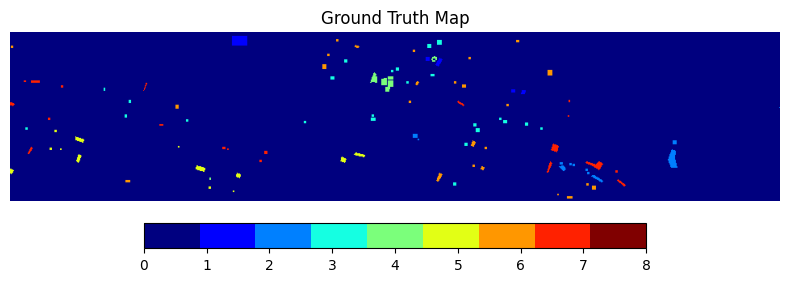

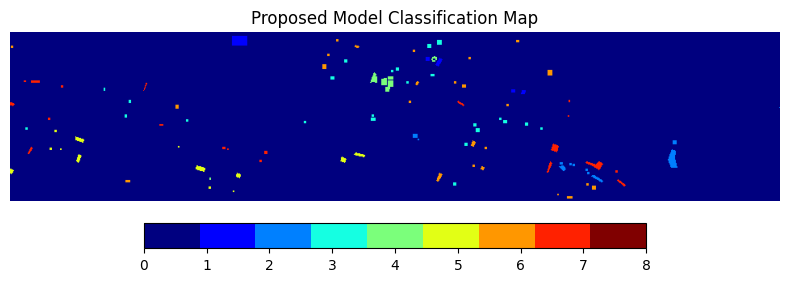

/tmp/ipython-input-4139372259.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


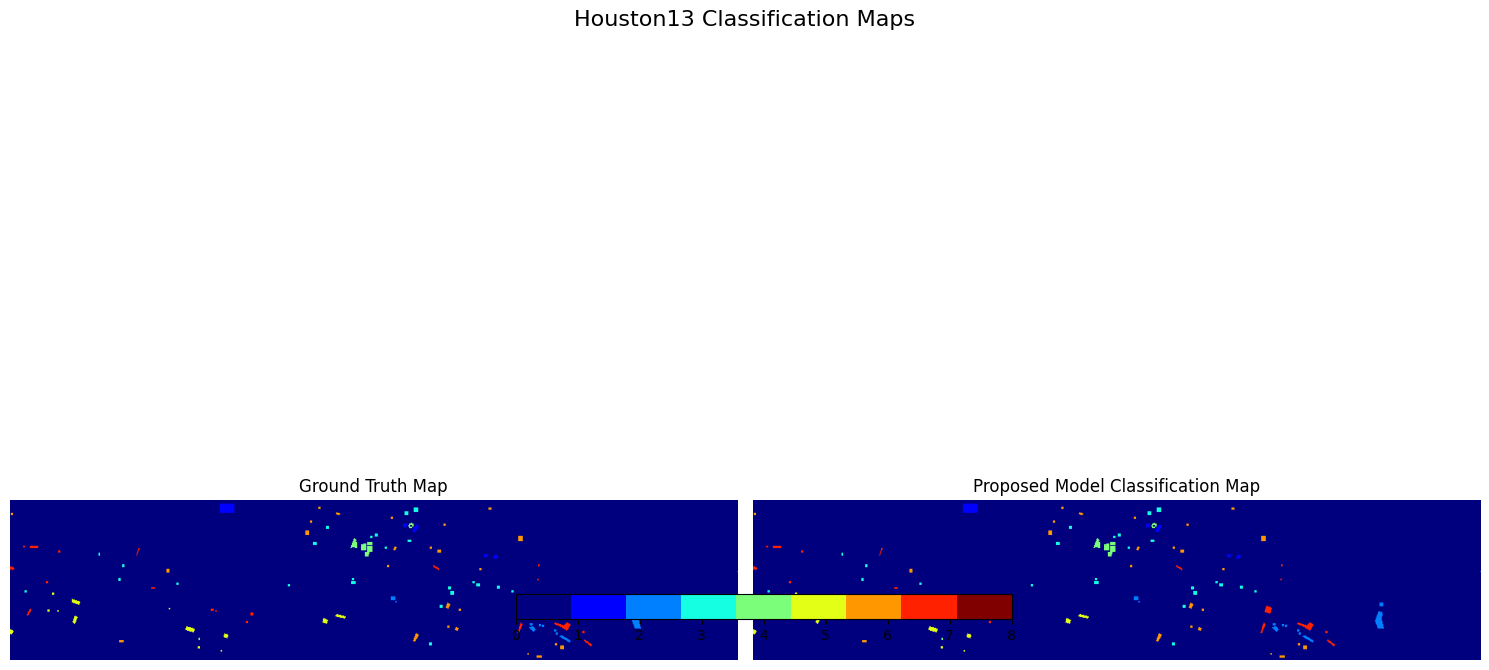

✅ Classification maps saved in 'classification_maps' folder:
  - Ground Truth: classification_maps/GT_classification_map.png
  - Proposed Model: classification_maps/Proposed_model_classification_map.png
  - Comparison: classification_maps/Houston13_comparison.png


In [68]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Create directory if it doesn't exist
os.makedirs("classification_maps", exist_ok=True)

# Create a colormap for visualization
num_classes = len(np.unique(gt))
colors = plt.cm.get_cmap('jet', num_classes + 1)  # +1 for background class

# Save Ground Truth Map separately
plt.figure(figsize=(8, 6))
plt.imshow(gt, cmap=colors, vmin=0, vmax=num_classes)
plt.title('Ground Truth Map')
plt.axis('off')
plt.colorbar(orientation='horizontal', fraction=0.046, pad=0.04)
plt.tight_layout()
plt.savefig("classification_maps/GT_classification_map.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# Save Proposed Model Map separately
plt.figure(figsize=(8, 6))
plt.imshow(classification_map_masked, cmap=colors, vmin=0, vmax=num_classes)
plt.title('Proposed Model Classification Map')
plt.axis('off')
plt.colorbar(orientation='horizontal', fraction=0.046, pad=0.04)
plt.tight_layout()
plt.savefig("classification_maps/Proposed_model_classification_map.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# Create and display the side-by-side comparison plot (optional)
fig, axes = plt.subplots(1, 2, figsize=(15, 7))
axes[0].imshow(gt, cmap=colors, vmin=0, vmax=num_classes)
axes[0].set_title('Ground Truth Map')
axes[0].axis('off')

axes[1].imshow(classification_map_masked, cmap=colors, vmin=0, vmax=num_classes)
axes[1].set_title('Proposed Model Classification Map')
axes[1].axis('off')

fig.colorbar(axes[1].images[0], ax=axes, orientation='horizontal', fraction=0.046, pad=0.04)
plt.suptitle("Houston13 Classification Maps", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("classification_maps/Houston13_comparison.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("✅ Classification maps saved in 'classification_maps' folder:")
print(f"  - Ground Truth: classification_maps/GT_classification_map.png")
print(f"  - Proposed Model: classification_maps/Proposed_model_classification_map.png")
print(f"  - Comparison: classification_maps/Houston13_comparison.png")

/tmp/ipython-input-3460144774.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('jet', num_classes + 1) # +1 for the background class
/tmp/ipython-input-3460144774.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


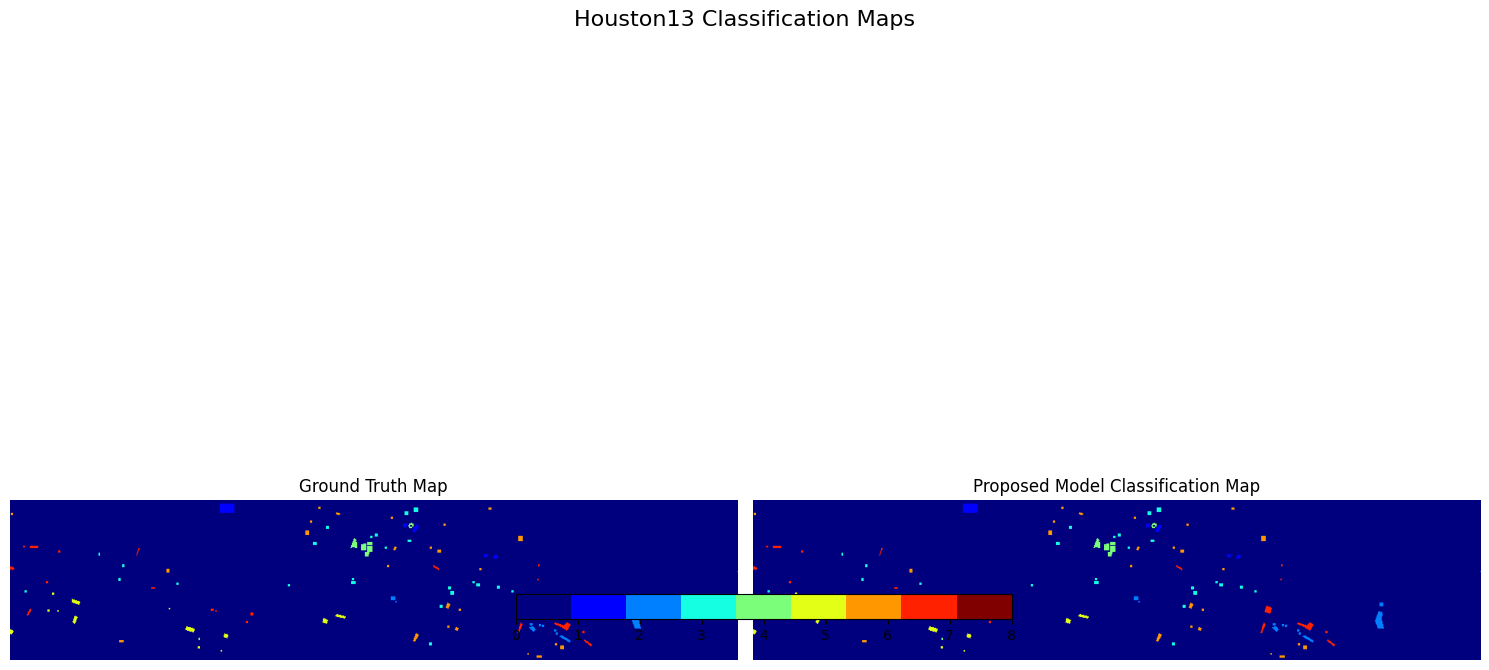

In [34]:
try:
    import matplotlib.pyplot as plt

    # Create a colormap for better visualization
    num_classes = len(np.unique(gt))
    colors = plt.cm.get_cmap('jet', num_classes + 1) # +1 for the background class

    fig, axes = plt.subplots(1, 2, figsize=(15, 7))

    # Plot the ground truth map
    ax1 = axes[0]
    im1 = ax1.imshow(gt, cmap=colors, vmin=0, vmax=num_classes)
    ax1.set_title('Ground Truth Map')
    ax1.axis('off')

    # Plot the predicted classification map
    ax2 = axes[1]
    im2 = ax2.imshow(classification_map_masked, cmap=colors, vmin=0, vmax=num_classes)
    ax2.set_title('Proposed Model Classification Map')
    ax2.axis('off')

    # Add a colorbar
    fig.colorbar(im2, ax=axes, orientation='horizontal', fraction=0.046, pad=0.04)

    plt.suptitle("Houston13 Classification Maps", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig("houston13_prop+gt_classification_maps.png", dpi=300, bbox_inches='tight')
    plt.show()
except ImportError:
    print("Matplotlib not installed. Skipping visualization.")
    print("To install, run: pip install matplotlib")

In [ ]:
loss, acc = new_model.evaluate([X_test, X_test_topo], y_test_cat)
print(f"✅ Houston13 Test Accuracy: {acc*100:.2f}%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9970 - loss: 0.0112
✅ Houston13 Test Accuracy: 99.80%


In [39]:
new_model.save("houston_model.keras")
#new_model.save('houston_model.h5')

In [40]:
results = {}
pred_labels = {}

In [41]:
# --- Utility Functions ---
def evaluate_model(y_true, y_pred, name):
    oa = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    cls_report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    f1_per_class = f1_score(y_true, y_pred, average=None, zero_division=0)
    aa = np.mean(np.diag(cm) / np.sum(cm, axis=1))
    kappa = cohen_kappa_score(y_true, y_pred)
    miou = np.mean([
        cm[i, i] / (np.sum(cm[i, :]) + np.sum(cm[:, i]) - cm[i, i])
        if (np.sum(cm[i, :]) + np.sum(cm[:, i]) - cm[i, i]) != 0 else 0
        for i in range(len(np.unique(y_true)))
    ])
    return {
        'OA': oa, 'AA': aa, 'Kappa': kappa, 'F1_per_class': f1_per_class, 'mIoU': miou
    }

def reconstruct_from_test_preds(preds_1d, test_indices, height, width):
    pred_map = np.zeros(height * width, dtype=np.uint8)
    pred_map[test_indices] = preds_1d + 1  # +1 to match GT labels
    return pred_map.reshape(height, width)

Classification Report:

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        69
           1     1.0000    1.0000    1.0000        73
           2     1.0000    1.0000    1.0000        73
           3     1.0000    1.0000    1.0000        57
           4     1.0000    1.0000    1.0000        64
           5     1.0000    1.0000    1.0000        81
           6     1.0000    1.0000    1.0000        89

    accuracy                         1.0000       506
   macro avg     1.0000    1.0000    1.0000       506
weighted avg     1.0000    1.0000    1.0000       506



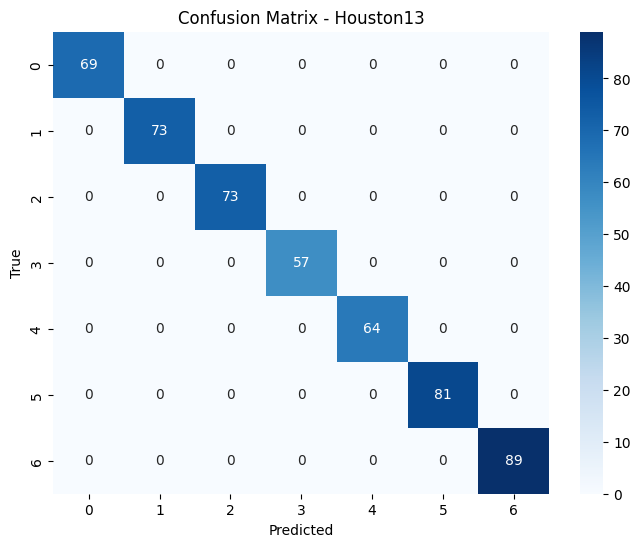

✅ Metrics on Houston13:
Overall Accuracy (OA): 100.00%
Average Accuracy (AA): 100.00%
Macro F1-score: 1.0000
Mean IoU (mIoU): 1.0000
Cohen's Kappa: 1.0000
Per-Class F1-scores: [1. 1. 1. 1. 1. 1. 1.]
Per-Class Recall: [1. 1. 1. 1. 1. 1. 1.]


In [42]:
y_pred_probs = new_model.predict([X_test, X_test_topo], verbose=0)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_true_labels = np.argmax(y_test_cat, axis=1)
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:\n")
print(classification_report(y_true_labels, y_pred_labels, digits=4))
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Houston13")
plt.show()
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, jaccard_score

oa = accuracy_score(y_true_labels, y_pred_labels)
recall_per_class = recall_score(y_true_labels, y_pred_labels, average=None)
aa = np.mean(recall_per_class)
f1_macro = f1_score(y_true_labels, y_pred_labels, average='macro')
f1_per_class = f1_score(y_true_labels, y_pred_labels, average=None)
miou = jaccard_score(y_true_labels, y_pred_labels, average='macro')
kappa = cohen_kappa_score(y_true_labels, y_pred_labels)

# Print everything
print(f"✅ Metrics on Houston13:")
print(f"Overall Accuracy (OA): {oa*100:.2f}%")
print(f"Average Accuracy (AA): {aa*100:.2f}%")
print(f"Macro F1-score: {f1_macro:.4f}")
print(f"Mean IoU (mIoU): {miou:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")
print(f"Per-Class F1-scores: {f1_per_class}")
print(f"Per-Class Recall: {recall_per_class}")

In [43]:
precision_macro = precision_score(y_true_labels, y_pred_labels, average='macro', zero_division=0)
recall_macro = recall_score(y_true_labels, y_pred_labels, average='macro', zero_division=0)

results['Proposed'] = {
    'OA': oa,
    'AA': aa,
    'Precision': precision_macro,
    'Recall': recall_macro,
    'F1': f1_macro,
    'Kappa': kappa,
    'mIoU': miou,
    'F1_per_class': f1_per_class
}
pred_labels['Proposed'] = y_pred_labels

In [44]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, cohen_kappa_score, jaccard_score

def evaluate_model(y_true, y_pred, name=''):
    oa = accuracy_score(y_true, y_pred)
    recall_per_class = recall_score(y_true, y_pred, average=None, zero_division=0)
    precision_per_class = precision_score(y_true, y_pred, average=None, zero_division=0)
    aa = np.mean(recall_per_class)

    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
    precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)

    miou = jaccard_score(y_true, y_pred, average='macro', zero_division=0)
    kappa = cohen_kappa_score(y_true, y_pred)
    f1_per_class = f1_score(y_true, y_pred, average=None, zero_division=0)

    return {
        'OA': oa,
        'AA': aa,
        'Precision': precision_macro,
        'Recall': recall_macro,
        'F1': f1_macro,
        'Kappa': kappa,
        'mIoU': miou,
        'F1_per_class': f1_per_class,
        'Precision_per_class': precision_per_class,
        'Recall_per_class': recall_per_class
    }

In [45]:
#reusable
y_train_cls = np.argmax(y_train_cat, axis=1)
y_test_cls = np.argmax(y_test_cat, axis=1)
NUM_CLASSES = y_train_cat.shape[1]

In [46]:
# 1. SVM on Topological Features
svm = SVC()
svm.fit(X_train_topo, y_train_cls)
svm_preds = svm.predict(X_test_topo)
results['SVM'] = evaluate_model(y_test_cls, svm_preds, 'SVM')
pred_labels['SVM'] = svm_preds

In [47]:
# 2. KNN on Topological Features
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_topo, y_train_cls)
knn_preds = knn.predict(X_test_topo)
results['KNN'] = evaluate_model(y_test_cls, knn_preds, 'KNN')
pred_labels['SVM'] = knn_preds

In [48]:
# 3. CNN on Spatial Patches
cnn = Sequential([
    Input(shape=(13,13,30)),
    Conv2D(32, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(NUM_CLASSES, activation='softmax')
])
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn.fit(X_train, y_train_cat, epochs=15, batch_size=32, verbose=0)
cnn_preds = np.argmax(cnn.predict(X_test, verbose=0), axis=1)
results['CNN'] = evaluate_model(y_test_cls, cnn_preds, 'CNN')
pred_labels['CNN'] = cnn_preds

In [49]:
# 4. CNN Encoder Variant
cnn_enc = Sequential([
    Input(shape=(13,13,30)),
    Conv2D(32, (3,3), activation='relu', padding='same'),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu', padding='same'),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(NUM_CLASSES, activation='softmax')
])
cnn_enc.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_enc.fit(X_train, y_train_cat, epochs=15, batch_size=32, verbose=0)
cnn_enc_preds = np.argmax(cnn_enc.predict(X_test, verbose=0), axis=1)
results['CNN_Encoder'] = evaluate_model(y_test_cls, cnn_enc_preds, 'CNN_Encoder')
pred_labels['CNN_Encoder'] = cnn_enc_preds

In [57]:
# 5. RNN on Band Sequences (reshape to sequences)
X_train_rnn = X_train.reshape((-1, 13*13, 30))  # (N, T, F)
X_test_rnn = X_test.reshape((-1, 13*13, 30))
rnn_input = Input(shape=(169, 30))
x = LSTM(64, return_sequences=False)(rnn_input)
x = Dense(32, activation='relu')(x)
rnn_output = Dense(NUM_CLASSES, activation='softmax')(x)
rnn_model = Model(rnn_input, rnn_output)
rnn_model.compile(optimizer=Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
rnn_model.fit(X_train_rnn, y_train_cat, epochs=15, batch_size=32, verbose=0)
rnn_preds = np.argmax(rnn_model.predict(X_test_rnn, verbose=0), axis=1)
results['RNN'] = evaluate_model(y_test_cls, rnn_preds, 'RNN')
pred_labels['RNN'] = rnn_preds

In [58]:
# 6. GTFN — A Simple Transformer-like Linear Projection
gtfn_input = Input(shape=(13,13,30))
x = Conv2D(64, (3,3), activation='relu', padding='same')(gtfn_input)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dense(NUM_CLASSES, activation='softmax')(x)
gtfn_model = Model(gtfn_input, x)
gtfn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
gtfn_model.fit(X_train, y_train_cat, epochs=15, batch_size=32, verbose=0)
gtfn_preds = np.argmax(gtfn_model.predict(X_test, verbose=0), axis=1)
results['GTFN'] = evaluate_model(y_test_cls, gtfn_preds, 'GTFN')
pred_labels['GTFN'] = gtfn_preds

In [64]:
def generate_classification_map(model_name, model, is_cnn=False):
    print(f"\nGenerating classification map for {model_name}...")
    all_y_pred_labels = []

    # Loop through the data in batches
    for i in range(0, total_pixels, INFERENCE_BATCH_SIZE):
        batch_start = i
        batch_end = min(i + INFERENCE_BATCH_SIZE, total_pixels)

        if is_cnn:
            # Prepare patches for CNN models
            batch_X = []
            for idx in range(batch_start, batch_end):
                row = idx // W
                col = idx % W
                patch = data_padded[row:row+PATCH_SIZE, col:col+PATCH_SIZE, :]
                batch_X.append(patch)
            batch_X = np.array(batch_X)
            batch_preds = np.argmax(model.predict(batch_X, verbose=0), axis=1)
        else:
            # Prepare topological features for SVM/KNN
            batch_X_topo = []
            for idx in range(batch_start, batch_end):
                row = idx // W
                col = idx % W
                patch = data_padded[row:row+PATCH_SIZE, col:col+PATCH_SIZE, :]
                topo_features = compute_persistence_entropy(patch)
                batch_X_topo.append(topo_features)
            batch_X_topo = np.array(batch_X_topo)
            batch_preds = model.predict(batch_X_topo)

        all_y_pred_labels.extend(batch_preds)
        print(f"Processed {batch_end} out of {total_pixels} pixels.")

    # Convert to numpy array and reshape to image dimensions
    classification_map = np.array(all_y_pred_labels).reshape(H, W)

    # Adjust labels if necessary (CNNs predict 0-indexed, SVM/KNN predict 1-indexed)
    if is_cnn:
        classification_map += 1

    return classification_map


In [65]:
# Generate and plot classification maps for each model
classification_maps = {
    'SVM': generate_classification_map('SVM', svm),
    'KNN': generate_classification_map('KNN', knn),
    'CNN': generate_classification_map('CNN', cnn, is_cnn=True),
    'CNN_Encoder': generate_classification_map('CNN_Encoder', cnn_enc, is_cnn=True),
}


Generating classification map for SVM...
Processed 256 out of 200340 pixels.
Processed 512 out of 200340 pixels.
Processed 768 out of 200340 pixels.
Processed 1024 out of 200340 pixels.
Processed 1280 out of 200340 pixels.
Processed 1536 out of 200340 pixels.
Processed 1792 out of 200340 pixels.
Processed 2048 out of 200340 pixels.
Processed 2304 out of 200340 pixels.
Processed 2560 out of 200340 pixels.
Processed 2816 out of 200340 pixels.
Processed 3072 out of 200340 pixels.
Processed 3328 out of 200340 pixels.
Processed 3584 out of 200340 pixels.
Processed 3840 out of 200340 pixels.
Processed 4096 out of 200340 pixels.
Processed 4352 out of 200340 pixels.
Processed 4608 out of 200340 pixels.
Processed 4864 out of 200340 pixels.
Processed 5120 out of 200340 pixels.
Processed 5376 out of 200340 pixels.
Processed 5632 out of 200340 pixels.
Processed 5888 out of 200340 pixels.
Processed 6144 out of 200340 pixels.
Processed 6400 out of 200340 pixels.
Processed 6656 out of 200340 pixels.

In [60]:
def generate_classification_map_cnn_like(model, model_name):
    """Generates a classification map for CNN-based models (CNN, CNN_Encoder, GTFN)."""
    print(f"\nGenerating classification map for {model_name}...")
    all_y_pred_labels = []

    for i in range(0, total_pixels, INFERENCE_BATCH_SIZE):
        batch_start = i
        batch_end = min(i + INFERENCE_BATCH_SIZE, total_pixels)
        batch_X = []

        for idx in range(batch_start, batch_end):
            row = idx // W
            col = idx % W
            patch = data_padded[row:row+PATCH_SIZE, col:col+PATCH_SIZE, :]
            batch_X.append(patch)

        batch_X = np.array(batch_X)
        batch_preds = np.argmax(model.predict(batch_X, verbose=0), axis=1)
        all_y_pred_labels.extend(batch_preds)
        print(f"Processed {batch_end} out of {total_pixels} pixels.")

    # CNN models predict 0-indexed labels, so we add 1 to match GT
    return (np.array(all_y_pred_labels) + 1).reshape(H, W)

def generate_classification_map_rnn(model, model_name):
    """Generates a classification map for RNN models."""
    print(f"\nGenerating classification map for {model_name}...")
    all_y_pred_labels = []

    for i in range(0, total_pixels, INFERENCE_BATCH_SIZE):
        batch_start = i
        batch_end = min(i + INFERENCE_BATCH_SIZE, total_pixels)
        batch_X = []

        for idx in range(batch_start, batch_end):
            row = idx // W
            col = idx % W
            patch = data_padded[row:row+PATCH_SIZE, col:col+PATCH_SIZE, :]
            batch_X.append(patch)

        batch_X = np.array(batch_X)
        # Reshape for the RNN model
        batch_X_rnn = batch_X.reshape((-1, PATCH_SIZE * PATCH_SIZE, data_selected.shape[-1]))

        batch_preds = np.argmax(model.predict(batch_X_rnn, verbose=0), axis=1)
        all_y_pred_labels.extend(batch_preds)
        print(f"Processed {batch_end} out of {total_pixels} pixels.")

    # RNN models predict 0-indexed labels, so we add 1 to match GT
    return (np.array(all_y_pred_labels) + 1).reshape(H, W)



In [61]:
rnn_map = generate_classification_map_rnn(rnn_model, 'RNN')
gtfn_map = generate_classification_map_cnn_like(gtfn_model, 'GTFN')


Generating classification map for RNN...
Processed 256 out of 200340 pixels.
Processed 512 out of 200340 pixels.
Processed 768 out of 200340 pixels.
Processed 1024 out of 200340 pixels.
Processed 1280 out of 200340 pixels.
Processed 1536 out of 200340 pixels.
Processed 1792 out of 200340 pixels.
Processed 2048 out of 200340 pixels.
Processed 2304 out of 200340 pixels.
Processed 2560 out of 200340 pixels.
Processed 2816 out of 200340 pixels.
Processed 3072 out of 200340 pixels.
Processed 3328 out of 200340 pixels.
Processed 3584 out of 200340 pixels.
Processed 3840 out of 200340 pixels.
Processed 4096 out of 200340 pixels.
Processed 4352 out of 200340 pixels.
Processed 4608 out of 200340 pixels.
Processed 4864 out of 200340 pixels.
Processed 5120 out of 200340 pixels.
Processed 5376 out of 200340 pixels.
Processed 5632 out of 200340 pixels.
Processed 5888 out of 200340 pixels.
Processed 6144 out of 200340 pixels.
Processed 6400 out of 200340 pixels.
Processed 6656 out of 200340 pixels.

In [66]:
classification_maps

{'SVM': array([[5, 5, 5, ..., 1, 1, 1],
        [5, 5, 5, ..., 1, 1, 1],
        [5, 5, 5, ..., 1, 1, 1],
        ...,
        [3, 3, 3, ..., 5, 5, 5],
        [3, 3, 3, ..., 5, 5, 5],
        [3, 3, 3, ..., 5, 5, 5]]),
 'KNN': array([[5, 5, 5, ..., 1, 1, 1],
        [5, 5, 5, ..., 5, 5, 5],
        [5, 5, 5, ..., 5, 5, 5],
        ...,
        [4, 4, 4, ..., 5, 5, 5],
        [4, 4, 4, ..., 5, 5, 5],
        [4, 4, 4, ..., 5, 5, 5]]),
 'CNN': array([[6, 6, 6, ..., 4, 4, 4],
        [6, 6, 6, ..., 4, 4, 4],
        [6, 6, 6, ..., 4, 4, 4],
        ...,
        [5, 5, 5, ..., 6, 6, 6],
        [5, 5, 5, ..., 6, 6, 6],
        [5, 5, 5, ..., 6, 6, 6]]),
 'CNN_Encoder': array([[6, 6, 7, ..., 6, 6, 6],
        [6, 6, 7, ..., 6, 6, 6],
        [6, 6, 6, ..., 6, 6, 6],
        ...,
        [6, 6, 6, ..., 6, 6, 6],
        [5, 5, 5, ..., 6, 6, 6],
        [5, 5, 5, ..., 6, 6, 6]])}

/tmp/ipython-input-4059248461.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('jet', num_classes + 1)


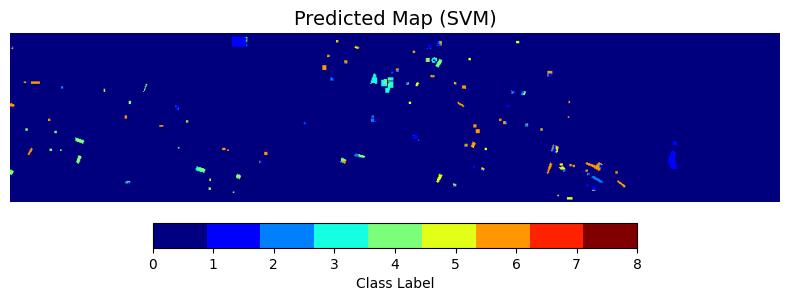

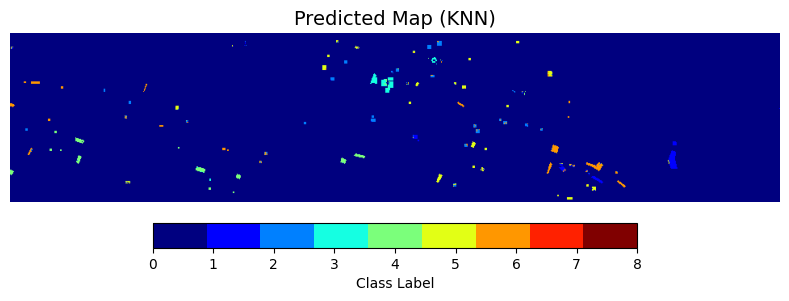

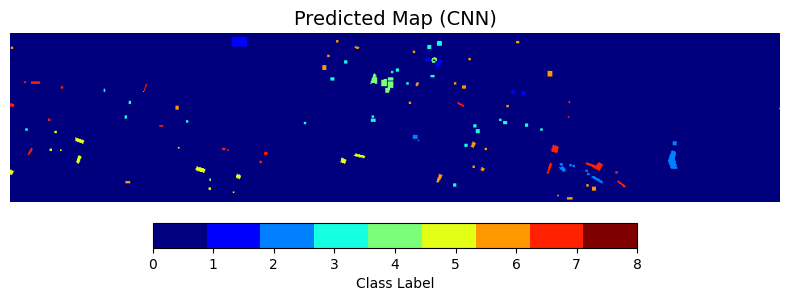

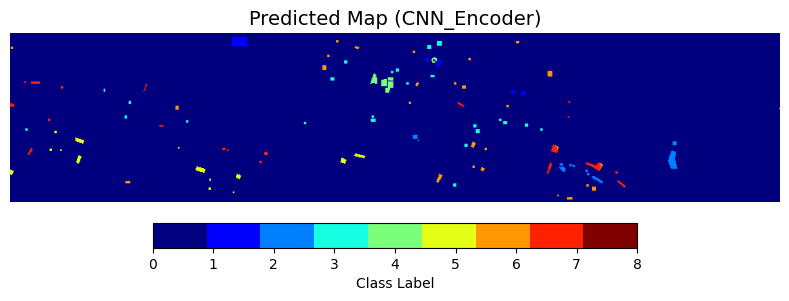

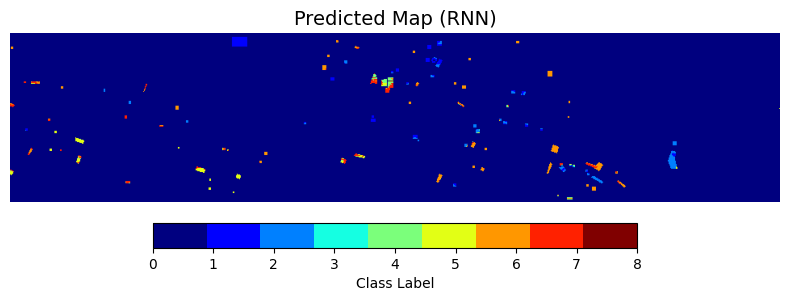

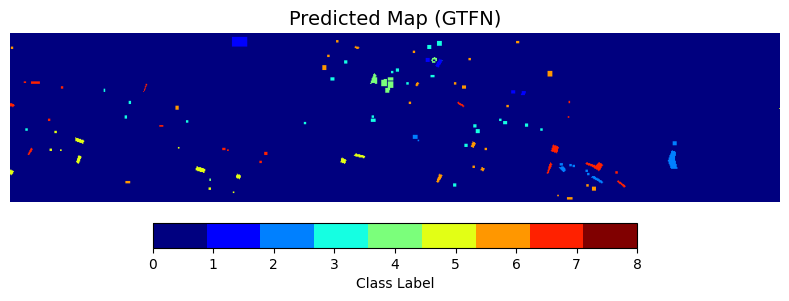

✅ All classification maps saved in 'classification_maps' folder.


In [67]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Optional: Save to a folder
os.makedirs("classification_maps", exist_ok=True)

# Colormap setup
num_classes = len(np.unique(gt))
colors = plt.cm.get_cmap('jet', num_classes + 1)

# --- Save Ground Truth first ---
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(gt, cmap=colors, vmin=0, vmax=num_classes)
ax.set_title('Ground Truth Map', fontsize=14)
ax.axis('off')
cbar = fig.colorbar(im, orientation='horizontal', fraction=0.046, pad=0.04)
cbar.set_label('Class Label')
plt.tight_layout()
plt.savefig("classification_maps/GT_classification_map.png", dpi=300, bbox_inches='tight')
plt.close()

# --- Save maps from classification_maps dict ---
for name, cmap_data in classification_maps.items():
    # Mask background
    masked_map = cmap_data.copy()
    masked_map[gt == 0] = 0

    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(masked_map, cmap=colors, vmin=0, vmax=num_classes)
    ax.set_title(f'Predicted Map ({name})', fontsize=14)
    ax.axis('off')
    cbar = fig.colorbar(im, orientation='horizontal', fraction=0.046, pad=0.04)
    cbar.set_label('Class Label')
    plt.tight_layout()
    # Safe filename
    filename = name.replace(" ", "_").replace("/", "_")
    plt.savefig(f"classification_maps/{filename}_classification_map.png", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

# --- Save RNN map ---
rnn_masked = rnn_map.copy()
rnn_masked[gt == 0] = 0

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(rnn_masked, cmap=colors, vmin=0, vmax=num_classes)
ax.set_title('Predicted Map (RNN)', fontsize=14)
ax.axis('off')

cbar = fig.colorbar(im, orientation='horizontal', fraction=0.046, pad=0.04)
cbar.set_label('Class Label')
plt.tight_layout()
plt.savefig("classification_maps/RNN_classification_map.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# --- Save GTFN map ---
gtfn_masked = gtfn_map.copy()
gtfn_masked[gt == 0] = 0

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(gtfn_masked, cmap=colors, vmin=0, vmax=num_classes)
ax.set_title('Predicted Map (GTFN)', fontsize=14)
ax.axis('off')
cbar = fig.colorbar(im, orientation='horizontal', fraction=0.046, pad=0.04)
cbar.set_label('Class Label')

plt.tight_layout()
plt.savefig("classification_maps/GTFN_classification_map.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("✅ All classification maps saved in 'classification_maps' folder.")


In [63]:
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Setup colormap
num_classes = len(np.unique(gt))
colors = plt.cm.get_cmap('jet', num_classes + 1)

# First save Ground Truth map
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(gt, cmap=colors, vmin=0, vmax=num_classes)
ax.set_title('Ground Truth Map', fontsize=14)
ax.axis('off')

# Colorbar
cbar = fig.colorbar(im, orientation='horizontal', fraction=0.046, pad=0.04)
cbar.set_label('Class Label')

plt.tight_layout()
plt.savefig(f"GT_classification_map.png", dpi=300, bbox_inches='tight')
plt.close()

# Now save each model map separately
for name, cmap_data in classification_maps.items():
    # Mask the predicted map
    masked_map = cmap_data.copy()
    masked_map[gt == 0] = 0

    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(masked_map, cmap=colors, vmin=0, vmax=num_classes)
    ax.set_title(f'Predicted Map ({name})', fontsize=14)
    ax.axis('off'

    )
    # Colorbar
    cbar = fig.colorbar(im, orientation='horizontal', fraction=0.046, pad=0.04)
    cbar.set_label('Class Label')

    plt.tight_layout()
    plt.savefig(f"{name}_classification_map.png", dpi=300, bbox_inches='tight')
    plt.close()

/tmp/ipython-input-2179591020.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('jet', num_classes + 1)
/tmp/ipython-input-2179591020.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 0.96])


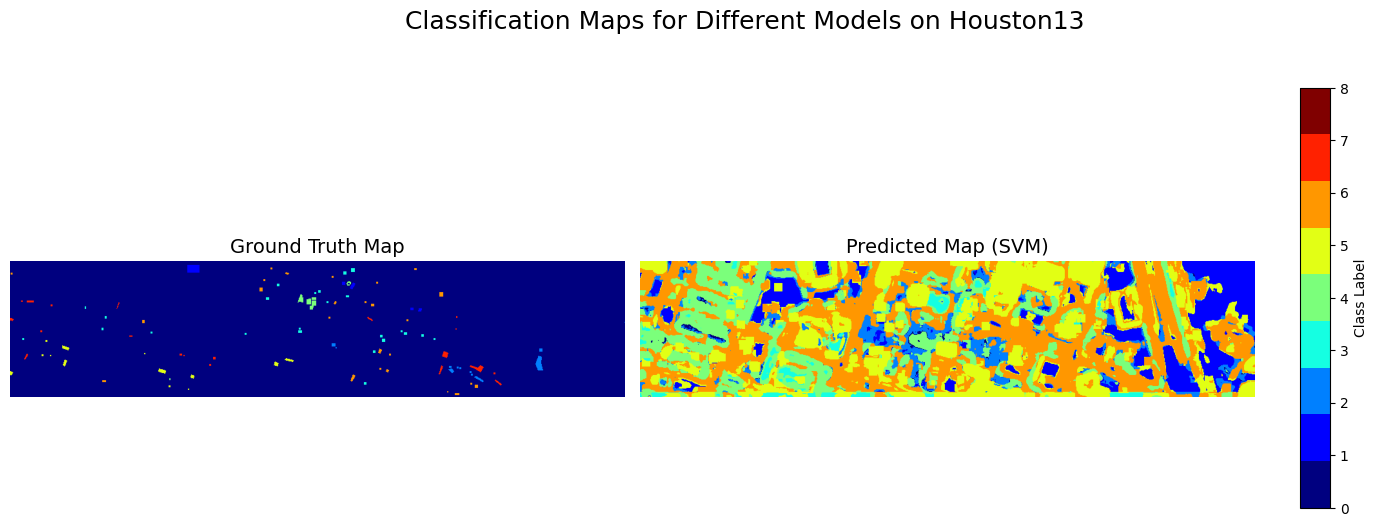

In [56]:
try:
    num_models = len(classification_maps)
    num_cols = 2
    num_rows = (num_models + 1 + num_cols - 1) // num_cols # +1 for GT

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 6))
    axes = axes.flatten()

    num_classes = len(np.unique(gt))
    colors = plt.cm.get_cmap('jet', num_classes + 1)

    # Plot Ground Truth first
    axes[0].imshow(gt, cmap=colors, vmin=0, vmax=num_classes)
    axes[0].set_title('Ground Truth Map', fontsize=14)
    axes[0].axis('off')

    # Plot each classification map
    for i, (name, cmap_data) in enumerate(classification_maps.items()):
        ax = axes[i + 1]
        im = ax.imshow(cmap_data, cmap=colors, vmin=0, vmax=num_classes)
        ax.set_title(f'Predicted Map ({name})', fontsize=14)
        ax.axis('off')

    # Hide any unused subplots
    for i in range(len(classification_maps) + 1, len(axes)):
        axes[i].axis('off')

    # Add a single colorbar for all plots
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.87, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax, ticks=np.arange(num_classes + 1), label='Class Label')

    plt.suptitle("Classification Maps for Different Models on Houston13", fontsize=18)
    plt.tight_layout(rect=[0, 0, 0.85, 0.96])
    plt.savefig("houston13_classification_maps.png", dpi=300, bbox_inches='tight')

    plt.show()

except ImportError:
    print("Matplotlib not installed. Skipping visualization.")
    print("To install, run: pip install matplotlib")


In [ ]:
# 📊 Print Final Results Summary
class_names = [f'Class {i+1}' for i in range(NUM_CLASSES)]

for model_name, metrics in results.items():
    print(f"\n📊 F1-Score per Class for {model_name}:")
    for cls_name, f1_val in zip(class_names, metrics['F1_per_class']):
        print(f"{cls_name}: {f1_val:.4f}")


📊 F1-Score per Class for Proposed:
Class 1: 1.0000
Class 2: 0.9931
Class 3: 1.0000
Class 4: 1.0000
Class 5: 0.9922
Class 6: 1.0000
Class 7: 1.0000

📊 F1-Score per Class for SVM:
Class 1: 0.1333
Class 2: 0.4900
Class 3: 0.3459
Class 4: 0.8036
Class 5: 0.6184
Class 6: 0.4882
Class 7: 0.6479

📊 F1-Score per Class for KNN:
Class 1: 0.8550
Class 2: 0.8571
Class 3: 0.8000
Class 4: 0.9189
Class 5: 0.9104
Class 6: 0.8917
Class 7: 0.8542

📊 F1-Score per Class for CNN:
Class 1: 1.0000
Class 2: 0.9931
Class 3: 1.0000
Class 4: 1.0000
Class 5: 0.9922
Class 6: 1.0000
Class 7: 1.0000

📊 F1-Score per Class for CNN_Encoder:
Class 1: 0.9927
Class 2: 0.9863
Class 3: 1.0000
Class 4: 1.0000
Class 5: 0.9922
Class 6: 1.0000
Class 7: 1.0000

📊 F1-Score per Class for RNN:
Class 1: 0.0000
Class 2: 0.5070
Class 3: 0.0494
Class 4: 0.4865
Class 5: 0.6627
Class 6: 0.5294
Class 7: 0.6909

📊 F1-Score per Class for GTFN:
Class 1: 1.0000
Class 2: 0.9931
Class 3: 1.0000
Class 4: 1.0000
Class 5: 0.9922
Class 6: 1.0000
C

## training percentages

In [ ]:
# Step 1: Extract all topo features for full dataset
topo_features = np.array([compute_persistence_entropy(p) for p in X_patches])
y_cls = y.flatten() - 1  # Shift labels to 0-based for sklearn models if needed

# Step 2: Evaluation loop
percentages = [0.30, 0.50, 0.70, 0.80, 0.90]
results_by_percent = {}

for pct in percentages:
    print(f"\nEvaluating for {int(pct*100)}% training data...")

    # Split data
    X_train_sp, X_test_sp, X_train_topo, X_test_topo, y_train_cls, y_test_cls = train_test_split(
        X_patches, topo_features, y_cls, test_size=(1 - pct), stratify=y_cls, random_state=42
    )

    y_train_cat = encoder.fit_transform(y_train_cls.reshape(-1, 1))
    y_test_cat = encoder.transform(y_test_cls.reshape(-1, 1))

    # Prepare models
    results_pct = {}
    pred_labels_pct = {}


    X_train_sp_np = np.array(X_train_sp)
    X_test_sp_np = np.array(X_test_sp)

    # Train Proposed Model
    new_model.fit([X_train_sp_np, X_train_topo], y_train_cat, epochs=15, batch_size=32, verbose=0)

    # Predict
    y_pred_probs = new_model.predict([X_test_sp_np, X_test_topo], verbose=0)
    y_pred_labels = np.argmax(y_pred_probs, axis=1)
    y_true_labels = np.argmax(y_test_cat, axis=1)
    oa = accuracy_score(y_true_labels, y_pred_labels)
    recall_per_class = recall_score(y_true_labels, y_pred_labels, average=None, zero_division=0)
    aa = np.mean(recall_per_class)
    f1_macro = f1_score(y_true_labels, y_pred_labels, average='macro', zero_division=0)
    f1_per_class = f1_score(y_true_labels, y_pred_labels, average=None, zero_division=0)
    miou = jaccard_score(y_true_labels, y_pred_labels, average='macro', zero_division=0)
    kappa = cohen_kappa_score(y_true_labels, y_pred_labels)
    precision_per_class = precision_score(y_true_labels, y_pred_labels, average=None, zero_division=0)
    recall_per_class = recall_score(y_true_labels, y_pred_labels, average=None, zero_division=0)

# Save results
    results_pct["Proposed"] = {
        "OA": oa,
        "AA": aa,
        "Kappa": kappa,
        "F1": f1_macro,
        "mIoU": miou,
        "F1_per_class": f1_per_class,
        "Precision_per_class": precision_per_class,
        "Recall_per_class": recall_per_class
    }
    pred_labels_pct["Proposed"] = y_pred_labels
    # SVM
    svm.fit(X_train_topo, y_train_cls)
    svm_preds = svm.predict(X_test_topo)
    results_pct["SVM"] = evaluate_model(y_test_cls, svm_preds)
    pred_labels_pct["SVM"] = svm_preds

    # KNN
    knn.fit(X_train_topo, y_train_cls)
    knn_preds = knn.predict(X_test_topo)
    results_pct["KNN"] = evaluate_model(y_test_cls, knn_preds)
    pred_labels_pct["KNN"] = knn_preds

    # CNN (spatial)
    cnn.fit(np.array(X_train_sp), y_train_cat, epochs=8, batch_size=32, verbose=0)
    cnn_preds = np.argmax(cnn.predict(np.array(X_test_sp), verbose=0), axis=1)
    results_pct["CNN"] = evaluate_model(y_test_cls, cnn_preds)
    pred_labels_pct["CNN"] = cnn_preds

    # CNN_Encoder
    cnn_enc.fit(np.array(X_train_sp), y_train_cat, epochs=8, batch_size=32, verbose=0)
    cnn_enc_preds = np.argmax(cnn_enc.predict(np.array(X_test_sp), verbose=0), axis=1)
    results_pct["CNN_Encoder"] = evaluate_model(y_test_cls, cnn_enc_preds)
    pred_labels_pct["CNN_Encoder"] = cnn_enc_preds

    # RNN
    X_patches = np.array(X_patches)  # Ensure it's a NumPy array
    X_train_rnn = np.array(X_train_sp).reshape((-1, PATCH_SIZE * PATCH_SIZE, X_patches.shape[-1]))
    X_test_rnn = np.array(X_test_sp).reshape((-1, PATCH_SIZE * PATCH_SIZE, X_patches.shape[-1]))
    rnn_model.fit(X_train_rnn, y_train_cat, epochs=15, batch_size=32, verbose=0)
    rnn_preds = np.argmax(rnn_model.predict(X_test_rnn, verbose=0), axis=1)
    results['RNN'] = evaluate_model(y_test_cls, rnn_preds, 'RNN')

    X_train_sp_np = np.array(X_train_sp)
    X_test_sp_np = np.array(X_test_sp)

    gtfn_model.fit(X_train_sp_np, y_train_cat, epochs=8, batch_size=32, verbose=0)
    gtfn_preds = np.argmax(gtfn_model.predict(X_test_sp_np, verbose=0), axis=1)
    results_pct["GTFN"] = evaluate_model(y_test_cls, gtfn_preds)
    pred_labels_pct["GTFN"] = gtfn_preds

    results_by_percent[f"{int(pct*100)}%"] = {
        model: {
            "OA": result["OA"],
            "AA": result["AA"],
            "Kappa": result["Kappa"],
            "F1": result["F1"],
            "mIoU": result["mIoU"],
            "F1_per_class": result["F1_per_class"],
            "Precision_per_class": result["Precision_per_class"],
            "Recall_per_class": result["Recall_per_class"]
        }
        for model, result in results_pct.items()
    }


Evaluating for 30% training data...

Evaluating for 50% training data...

Evaluating for 70% training data...

Evaluating for 80% training data...

Evaluating for 90% training data...


In [ ]:
results#results_by_percent#results

{'Proposed': {'OA': 0.9980237154150198,
  'AA': np.float64(0.9980430528375734),
  'Precision': 0.9978021978021978,
  'Recall': 0.9980430528375734,
  'F1': 0.9979073586130524,
  'Kappa': np.float64(0.9976873751708188),
  'mIoU': np.float64(0.9958452506397713),
  'F1_per_class': array([1.        , 0.99310345, 1.        , 1.        , 0.99224806,
         1.        , 1.        ])},
 'SVM': {'OA': 0.5316205533596838,
  'AA': np.float64(0.5343729672069432),
  'Precision': 0.597875831710632,
  'Recall': 0.5343729672069432,
  'F1': 0.5038952537874416,
  'Kappa': np.float64(0.45101216798967236),
  'mIoU': np.float64(0.3609095662535594),
  'F1_per_class': array([0.13333333, 0.49      , 0.34586466, 0.80357143, 0.61842105,
         0.48818898, 0.64788732]),
  'Precision_per_class': array([0.83333333, 0.38582677, 0.38333333, 0.81818182, 0.53409091,
         0.67391304, 0.55645161]),
  'Recall_per_class': array([0.07246377, 0.67123288, 0.31506849, 0.78947368, 0.734375  ,
         0.38271605, 0.77528

In [ ]:
def evaluate_all_models(X, X_topo, y_cat, y, train_fraction):
    results = {}
    # Split based on the given percentage
    X_train, X_test, X_train_topo, X_test_topo, y_train_cat, y_test_cat, y_train_cls, y_test_cls = train_test_split(
        X, X_topo, y_cat, y, train_size=train_fraction, stratify=y, random_state=42)

    num_classes = y_cat.shape[1]

    # ---------- Proposed Model ----------
    topo_preds = np.argmax(new_model.predict([X_test, X_test_topo], verbose=0), axis=1)
    topo_true = np.argmax(y_test_cat, axis=1)
    results['Proposed'] = evaluate_model(topo_true, topo_preds)

    # ---------- SVM ----------
    svm = SVC(kernel='rbf')
    svm.fit(X_train_topo, y_train_cls)
    svm_preds = svm.predict(X_test_topo)
    results['SVM'] = evaluate_model(y_test_cls, svm_preds)

    # ---------- KNN ----------
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train_topo, y_train_cls)
    knn_preds = knn.predict(X_test_topo)
    results['KNN'] = evaluate_model(y_test_cls, knn_preds)

    # ---------- CNN ----------
    cnn.fit(X_train, y_train_cat, epochs=10, batch_size=32, verbose=0)
    cnn_preds = np.argmax(cnn.predict(X_test, verbose=0), axis=1)
    results['CNN'] = evaluate_model(y_test_cls, cnn_preds)

    # ---------- CNN Encoder ----------
    cnn_enc.fit(X_train, y_train_cat, epochs=10, batch_size=32, verbose=0)
    cnn_enc_preds = np.argmax(cnn_enc.predict(X_test, verbose=0), axis=1)
    results['CNN_Encoder'] = evaluate_model(y_test_cls, cnn_enc_preds)

    # ---------- RNN ----------
    X_train_rnn = X_train.reshape((-1, 13*13, 30))
    X_test_rnn = X_test.reshape((-1, 13*13, 30))
    rnn_model.fit(X_train_rnn, y_train_cat, epochs=15, batch_size=32, verbose=0)
    rnn_preds = np.argmax(rnn_model.predict(X_test_rnn, verbose=0), axis=1)
    results['RNN'] = evaluate_model(y_test_cls, rnn_preds)

    # ---------- GTFN ----------
    gtfn_model.fit(X_train, y_train_cat, epochs=10, batch_size=32, verbose=0)
    gtfn_preds = np.argmax(gtfn_model.predict(X_test, verbose=0), axis=1)
    results['GTFN'] = evaluate_model(y_test_cls, gtfn_preds)

    return results

In [ ]:
results_by_percent

{'30%': {'Proposed': {'OA': 1.0,
   'AA': np.float64(1.0),
   'Kappa': np.float64(1.0),
   'F1': 1.0,
   'mIoU': np.float64(1.0),
   'F1_per_class': array([1., 1., 1., 1., 1., 1., 1.]),
   'Precision_per_class': array([1., 1., 1., 1., 1., 1., 1.]),
   'Recall_per_class': array([1., 1., 1., 1., 1., 1., 1.])},
  'SVM': {'OA': 0.5036702428006776,
   'AA': np.float64(0.5074058008085582),
   'Kappa': np.float64(0.4180196407422029),
   'F1': 0.46347298682143706,
   'mIoU': np.float64(0.33159737078027296),
   'F1_per_class': array([0.00819672, 0.47437775, 0.31556503, 0.8159204 , 0.57835821,
          0.4398977 , 0.6119951 ]),
   'Precision_per_class': array([0.5       , 0.37850467, 0.34579439, 0.81188119, 0.49520767,
          0.81904762, 0.49309665]),
   'Recall_per_class': array([0.00413223, 0.63529412, 0.29019608, 0.82      , 0.69506726,
          0.3006993 , 0.80645161])},
  'KNN': {'OA': 0.766798418972332,
   'AA': np.float64(0.7669946042537711),
   'Kappa': np.float64(0.7269378162805501

In [ ]:
print(percentages)
print(results_by_percent.keys())


[0.3, 0.5, 0.7, 0.8, 0.9]
dict_keys(['30%', '50%', '70%', '80%', '90%'])


In [ ]:
percentages_str

['30%', '50%', '70%', '80%', '90%']

In [ ]:
results_by_percent

{'30%': {'Proposed': {'OA': 1.0,
   'AA': np.float64(1.0),
   'Kappa': np.float64(1.0),
   'F1': 1.0,
   'mIoU': np.float64(1.0),
   'F1_per_class': array([1., 1., 1., 1., 1., 1., 1.]),
   'Precision_per_class': array([1., 1., 1., 1., 1., 1., 1.]),
   'Recall_per_class': array([1., 1., 1., 1., 1., 1., 1.])},
  'SVM': {'OA': 0.5036702428006776,
   'AA': np.float64(0.5074058008085582),
   'Kappa': np.float64(0.4180196407422029),
   'F1': 0.46347298682143706,
   'mIoU': np.float64(0.33159737078027296),
   'F1_per_class': array([0.00819672, 0.47437775, 0.31556503, 0.8159204 , 0.57835821,
          0.4398977 , 0.6119951 ]),
   'Precision_per_class': array([0.5       , 0.37850467, 0.34579439, 0.81188119, 0.49520767,
          0.81904762, 0.49309665]),
   'Recall_per_class': array([0.00413223, 0.63529412, 0.29019608, 0.82      , 0.69506726,
          0.3006993 , 0.80645161])},
  'KNN': {'OA': 0.766798418972332,
   'AA': np.float64(0.7669946042537711),
   'Kappa': np.float64(0.7269378162805501

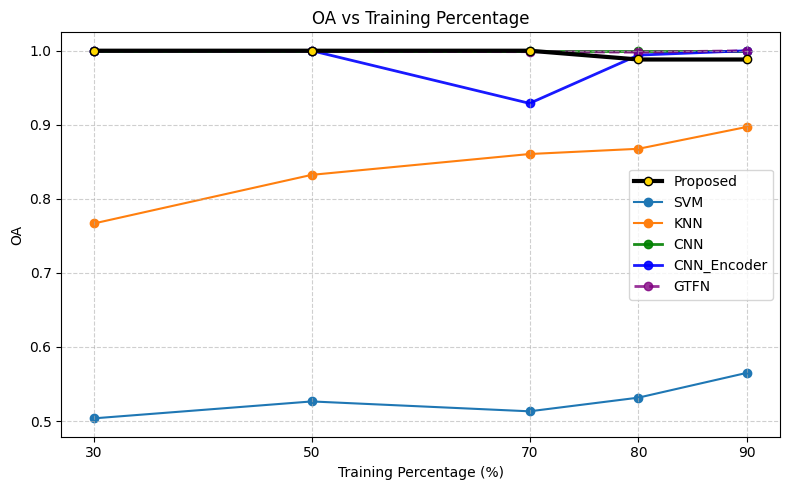

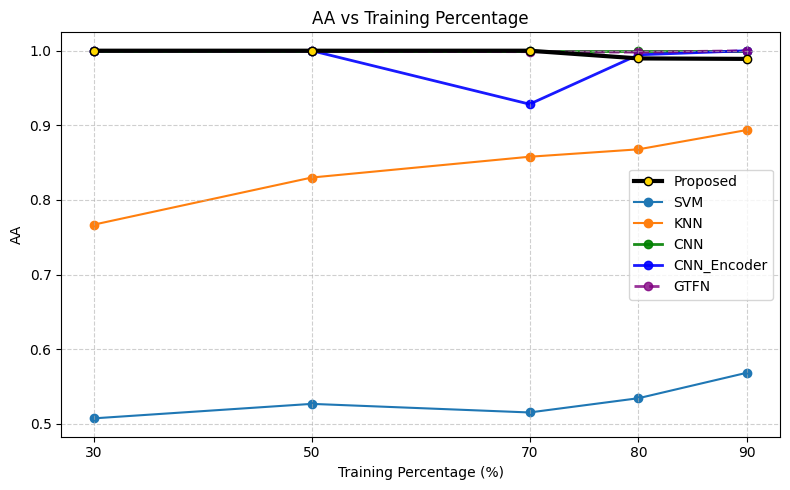

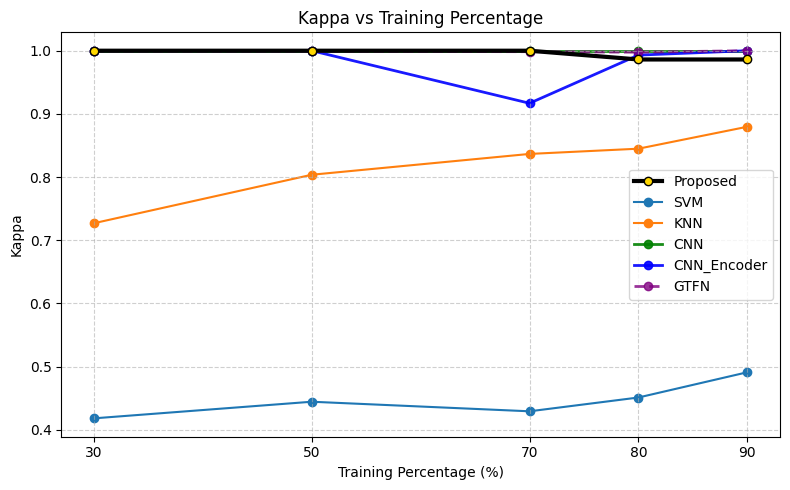

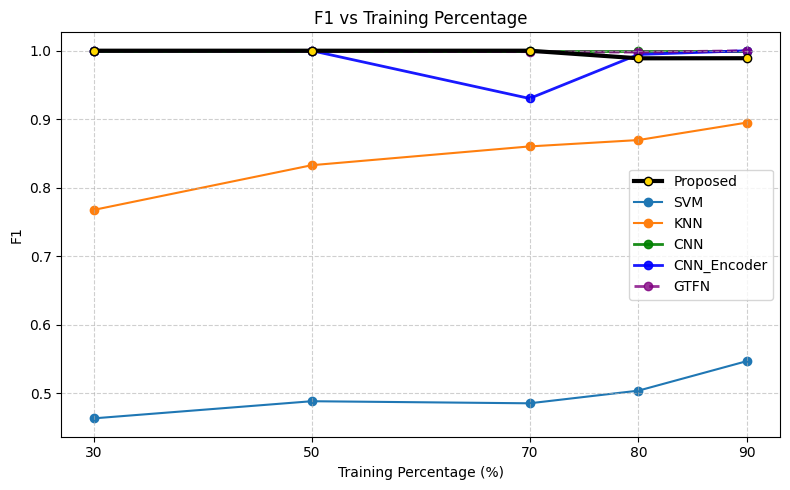

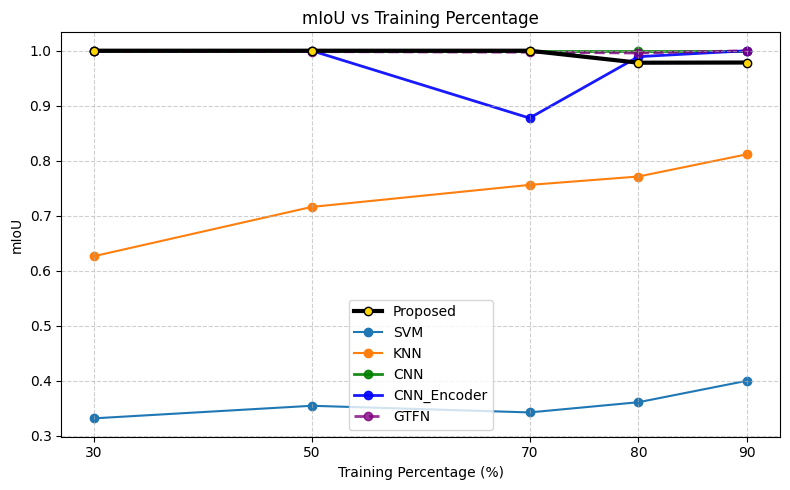

In [ ]:
import matplotlib.pyplot as plt
import os

model_styles = {
    "Proposed": {"color": "black", "linewidth": 3, "markerfacecolor": "gold", "zorder": 5},
    "CNN_Encoder": {"color": "blue", "linewidth": 2, "alpha": 0.9},
    "CNN": {"color": "green", "linewidth": 2, "alpha": 0.9},
    "GTFN": {"color": "purple", "linewidth": 2, "alpha": 0.8, "linestyle": "--"},
}

percentages = [0.3, 0.5, 0.7, 0.8, 0.9]
percentages_str = [f"{int(p * 100)}%" for p in percentages]
model_names = list(results_by_percent['30%'].keys())
metrics_to_plot = ["OA", "AA", "Kappa", "F1", "mIoU"]
save_dir = "plots"  # Change if needed
os.makedirs("plots", exist_ok=True)

for metric in metrics_to_plot:
    plt.figure(figsize=(8, 5))
    for model in model_names:
        y_vals = []
        for pct in percentages:
            pct_key = f"{int(pct * 100)}%"
            try:
                val = results_by_percent[pct_key][model][metric]
                if isinstance(val, np.ndarray):  # Handle per-class metrics safely
                    val = np.mean(val)
                y_vals.append(val)
            except KeyError:
                y_vals.append(np.nan)  # Handle missing values gracefully

        if all(np.isnan(y_vals)):
            continue  # Skip model if all values missing

        style = model_styles.get(model, {})  # Use defaults if style not found
        plt.plot(
            [int(p * 100) for p in percentages],
            y_vals,
            marker='o',
            label=model,
            linewidth=style.get("linewidth", 1.5),
            color=style.get("color", None),
            alpha=style.get("alpha", 1.0),
            linestyle=style.get("linestyle", "-"),
            zorder=style.get("zorder", 1),
            markerfacecolor=style.get("markerfacecolor", None),
        )

    plt.title(f'{metric} vs Training Percentage')
    plt.xlabel('Training Percentage (%)')
    plt.ylabel(metric)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.xticks([int(p * 100) for p in percentages])
    plt.tight_layout()
    plt.savefig(f"{save_dir}/{metric}_vs_training_percentage.png", dpi=300)
    plt.show()


In [ ]:
import pandas as pd

# Create class label index
class_labels = [f'Class {i+1}' for i in range(len(next(iter(results.values()))['F1_per_class']))]
df = pd.DataFrame(index=class_labels)

# Fill in F1 scores
for model_name, metrics in results.items():
    df[model_name] = metrics['F1_per_class']

# Insert separator row
df.loc['──────────'] = [''] * len(df.columns)

# Insert overall scores
df.loc['OA'] = [results[m]['OA'] * 100 for m in df.columns]
df.loc['AA'] = [results[m]['AA'] * 100 for m in df.columns]
df.loc['Kappa'] = [results[m]['Kappa'] * 100 for m in df.columns]

# Round values
df = df.round(4)

# Move 'Proposed' to the end
columns = [c for c in df.columns if c != 'Proposed'] + ['Proposed']
df = df[columns]

# Add 'Class' column and reset index
df.insert(0, 'Class', df.index)
df = df.reset_index(drop=True)

# Highlight max values in each row (skip first column)
def highlight_max(row):
    if row['Class'] == '──────────':
        return [''] * len(row)
    try:
        vals = row[1:].astype(float)
        is_max = vals == vals.max()
        return [''] + ['font-weight: bold' if v else '' for v in is_max]
    except:
        return [''] * len(row)

# Apply style and display
styled_df = df.style.apply(highlight_max, axis=1)
styled_df.hide(axis="index")
styled_df.to_html("houston_chart.html")
display(styled_df)

Class,SVM,KNN,CNN,CNN_Encoder,RNN,GTFN,Proposed
Class 1,0.133333,0.854962,0.977778,1.000000,1.000000,1.000000,1.000000
Class 2,0.490000,0.857143,0.986301,0.993103,0.972973,0.993103,0.993103
Class 3,0.345865,0.800000,0.986486,1.000000,0.958904,1.000000,1.000000
Class 4,0.803571,0.918919,1.000000,1.000000,0.962963,1.000000,1.000000
Class 5,0.618421,0.910448,0.992248,0.992248,0.933333,0.992248,0.992248
Class 6,0.488189,0.891720,1.000000,1.000000,0.876404,0.987500,1.000000
Class 7,0.647887,0.854167,1.000000,1.000000,0.906977,0.988889,1.000000
──────────,,,,,,,
OA,53.162055,86.758893,99.209486,99.802372,94.071146,99.407115,99.802372
AA,53.437297,86.787698,99.183187,99.804305,94.101436,99.451572,99.804305


## 3d f1 scores

/tmp/ipython-input-599408204.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors_per_model = cm.get_cmap('tab10', len(model_names))(np.arange(len(model_names)))
/tmp/ipython-input-599408204.py:36: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


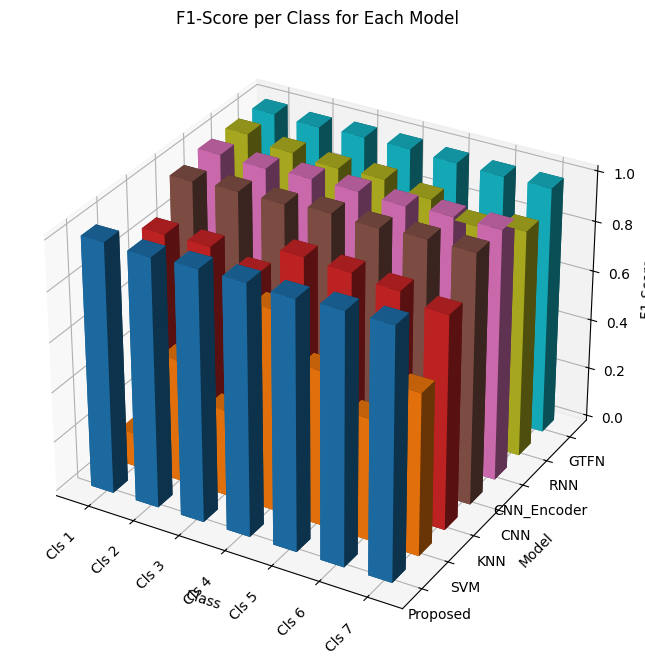

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

model_names = list(results.keys())
num_classes = len(results[model_names[0]]['F1_per_class'])

xpos, ypos = np.meshgrid(np.arange(num_classes), np.arange(len(model_names)))
xpos = xpos.flatten()
ypos = ypos.flatten()
zpos = np.zeros_like(xpos)

dx = dy = 0.5
dz = np.array([
    results[model]['F1_per_class'][cls_idx]
    for model in model_names
    for cls_idx in range(num_classes)
])

# Generate a color for each model and repeat it for all classes
colors_per_model = cm.get_cmap('tab10', len(model_names))(np.arange(len(model_names)))
bar_colors = np.array([colors_per_model[y] for y in ypos])

fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111, projection='3d')
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, shade=True, color=bar_colors)

ax.set_xticks(np.arange(num_classes) + dx / 2)
ax.set_xticklabels([f'Cls {i+1}' for i in range(num_classes)], rotation=45, ha='right')
ax.set_yticks(np.arange(len(model_names)) + dy / 2)
ax.set_yticklabels(model_names)
ax.set_xlabel('Class')
ax.set_ylabel('Model')
ax.set_zlabel('F1 Score')
ax.set_title('F1-Score per Class for Each Model')
plt.tight_layout()
plt.savefig("f1_per_class_3d_barplot.png", dpi=300, bbox_inches='tight')
plt.show()

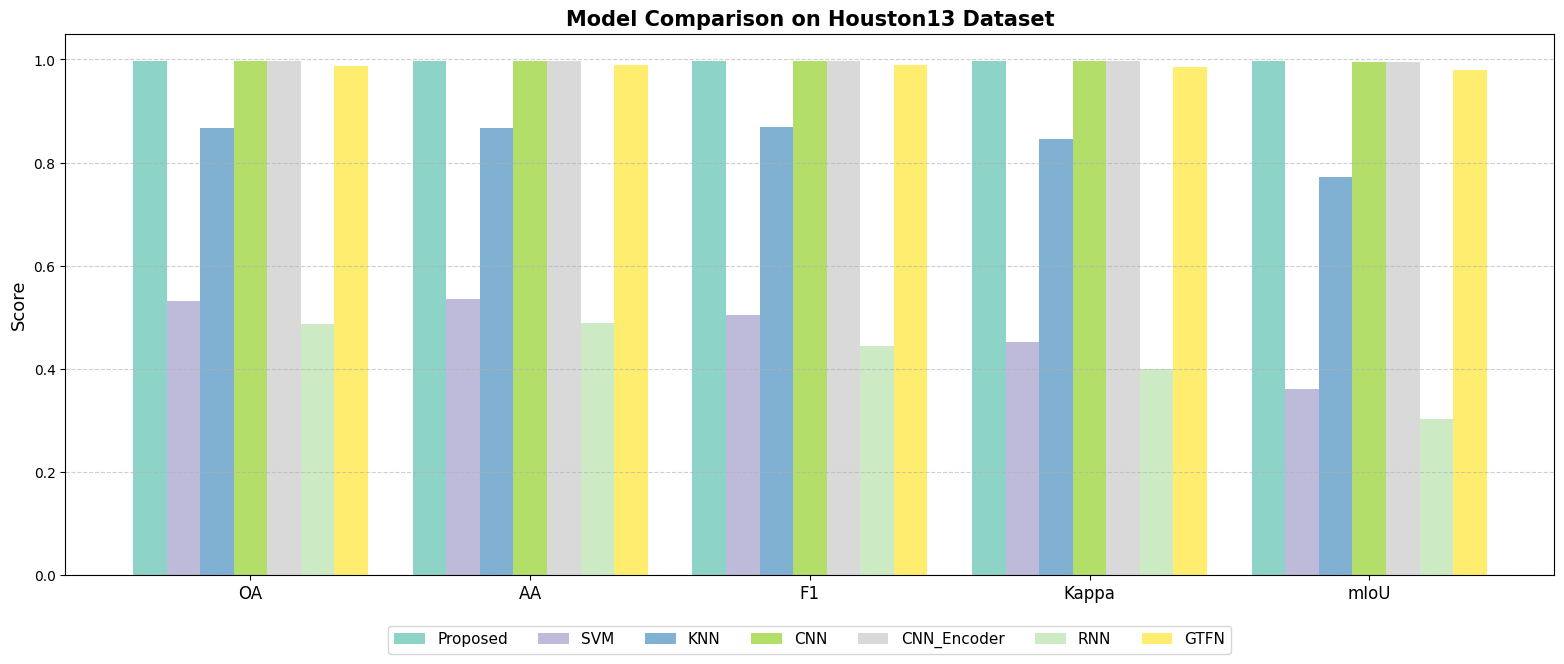

In [ ]:
import matplotlib.pyplot as plt

metrics_to_plot = ['OA', 'AA', 'F1', 'Kappa', 'mIoU']
model_names = list(results.keys())
num_models = len(model_names)
bar_width = 0.12
x = np.arange(len(metrics_to_plot))

# Custom color palette (optional)
colors = plt.cm.Set3(np.linspace(0, 1, num_models))

plt.figure(figsize=(16, 7))

for idx, model in enumerate(model_names):
    metric_vals = [results[model][metric] for metric in metrics_to_plot]
    plt.bar(x + idx * bar_width, metric_vals, width=bar_width, label=model, color=colors[idx])

# Center x-ticks
plt.xticks(x + bar_width * (num_models - 1) / 2, metrics_to_plot, fontsize=12)
plt.ylabel("Score", fontsize=13)
plt.title("Model Comparison on Houston13 Dataset", fontsize=15, fontweight='bold')

plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08), ncol=num_models, fontsize=11)
plt.tight_layout(pad=2)
plt.show()

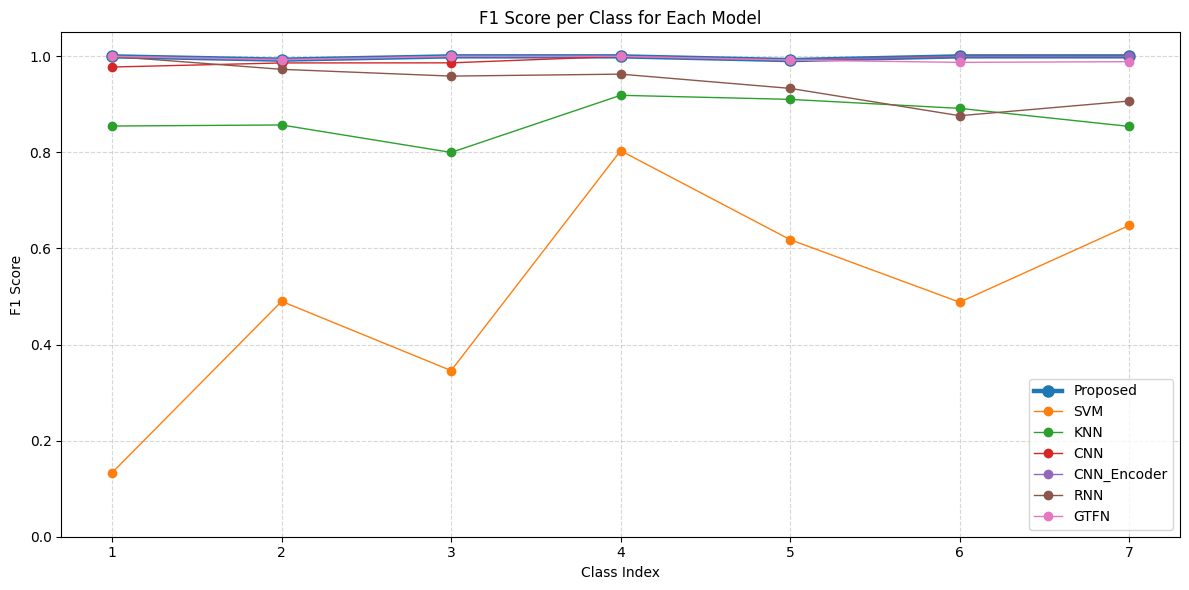

In [ ]:
plt.figure(figsize=(12, 6))

class_indices = np.arange(1, 8)  # 7 classes

for model_name, metrics in results.items():
    if model_name.lower() == 'proposed':
        plt.plot(class_indices, metrics['F1_per_class'],
                 marker='o', label=model_name, linewidth=3.2, markersize=8)
    else:
        plt.plot(class_indices, metrics['F1_per_class'],
                 marker='o', label=model_name, linewidth=1.0)

plt.xticks(class_indices)
plt.xlabel('Class Index')
plt.ylabel('F1 Score')
plt.title('F1 Score per Class for Each Model')
plt.grid(True, linestyle='--', alpha=0.5)
plt.ylim(0, 1.05)
plt.legend()
plt.tight_layout()
plt.savefig("f1_per_class_lineplot.png", dpi=300, bbox_inches='tight')
plt.show()

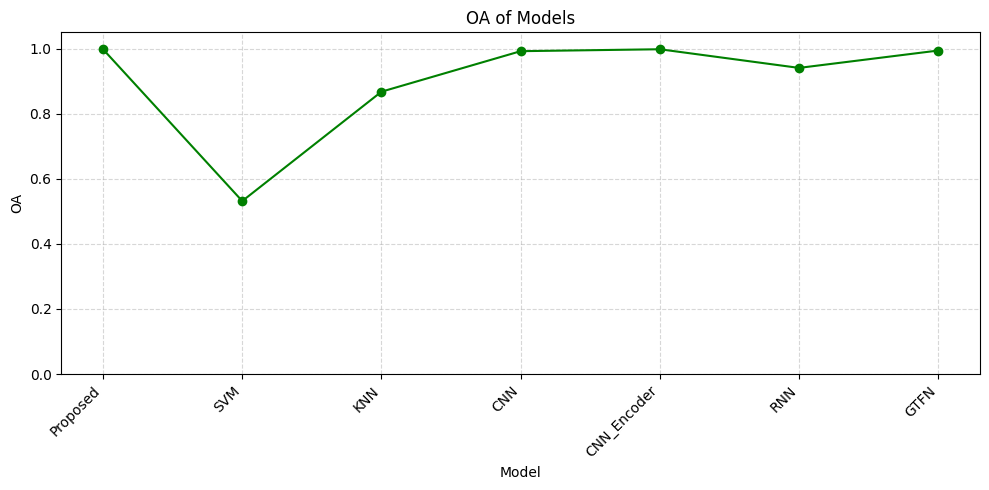

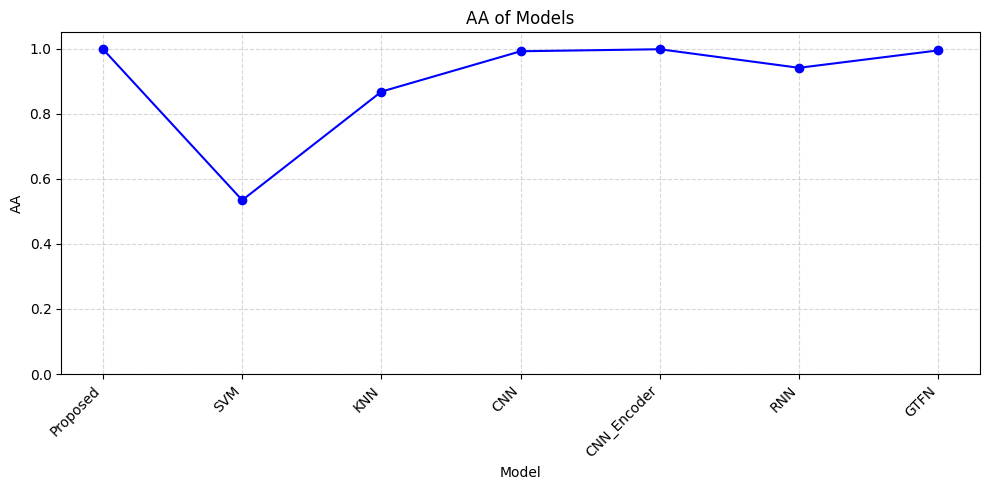

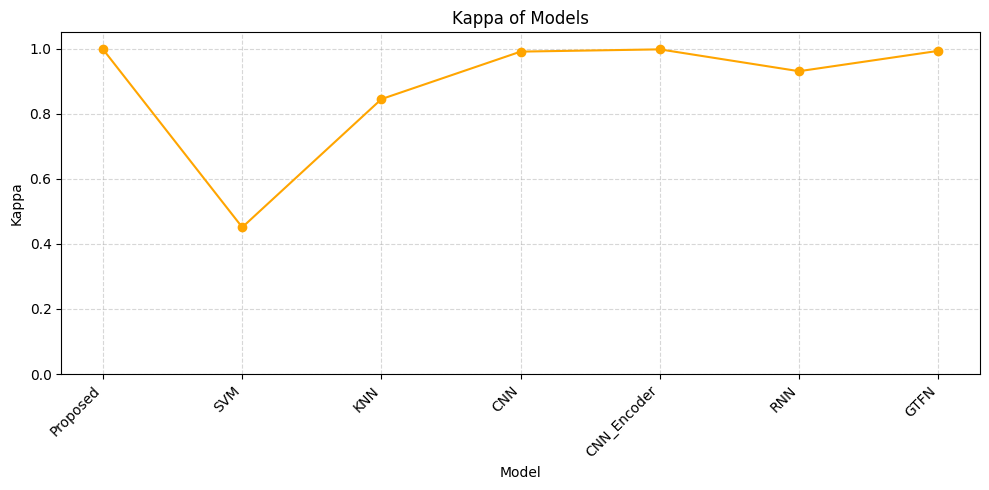

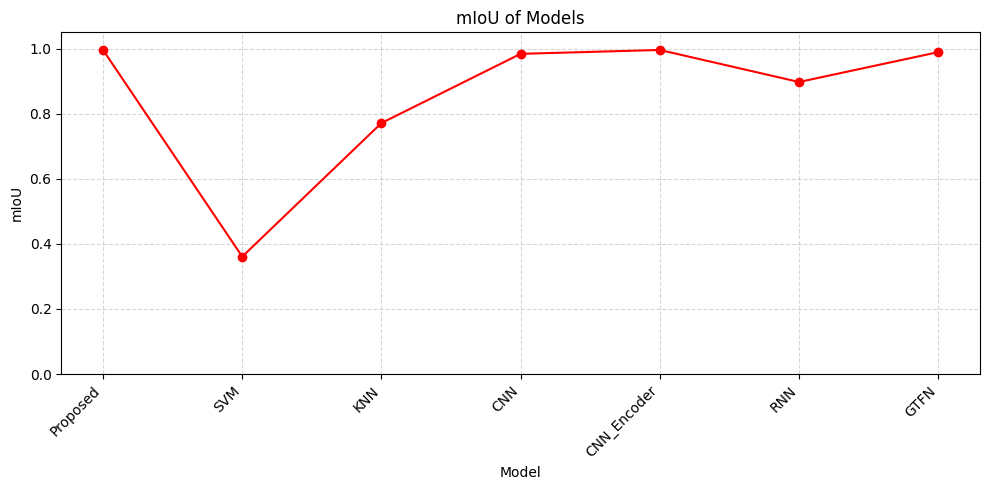

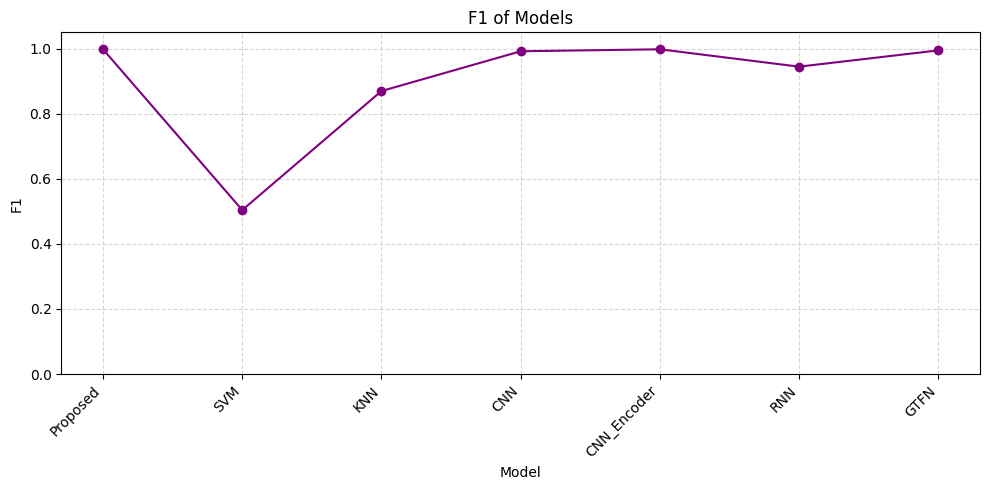

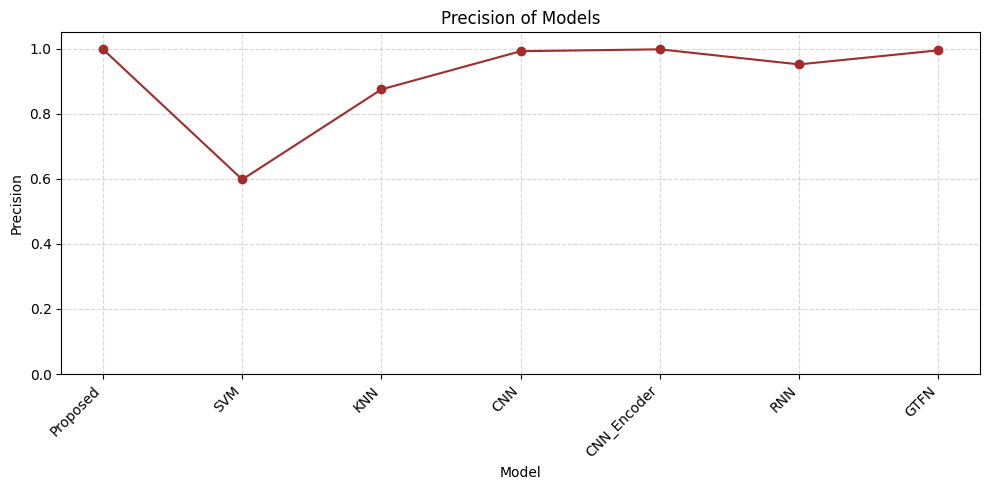

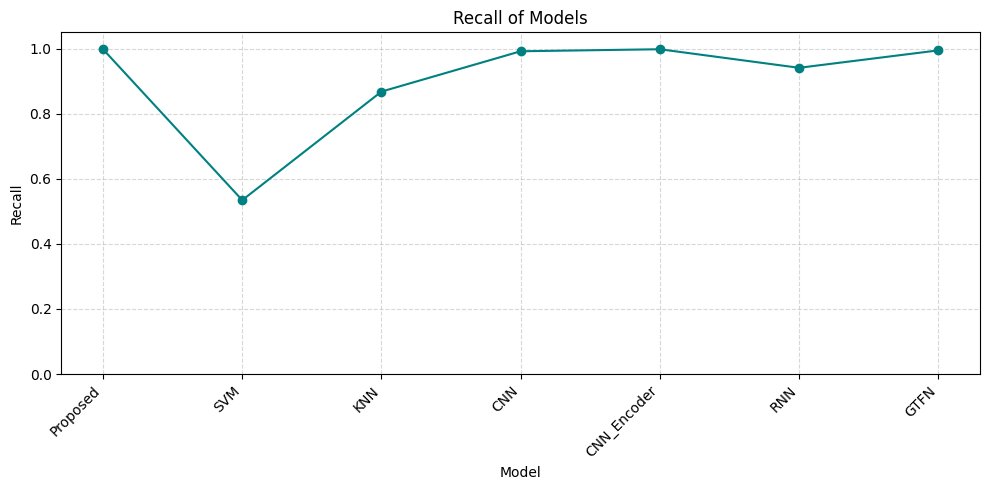

In [ ]:
metrics = ['OA', 'AA', 'Kappa', 'mIoU', 'F1','Precision','Recall']
colors = ['green', 'blue', 'orange', 'red', 'purple', 'brown', 'teal']  # Optional: customize if needed

for i, metric in enumerate(metrics):
    values = [results[model][metric] for model in results]

    plt.figure(figsize=(10, 5))
    plt.plot(list(results.keys()), values, marker='o', linestyle='-', color=colors[i % len(colors)])
    plt.ylim(0, 1.05)
    plt.xlabel('Model')
    plt.ylabel(metric)
    plt.title(f'{metric} of Models')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(f"{metric.lower().replace(' ', '_')}_comparison.png", dpi=300, bbox_inches='tight')
    plt.show()

pred maps done earlier already

In [ ]:
results

{'Proposed': {'OA': 0.9980237154150198,
  'AA': np.float64(0.9980430528375734),
  'Precision': 0.9978021978021978,
  'Recall': 0.9980430528375734,
  'F1': 0.9979073586130524,
  'Kappa': np.float64(0.9976873751708188),
  'mIoU': np.float64(0.9958452506397713),
  'F1_per_class': array([1.        , 0.99310345, 1.        , 1.        , 0.99224806,
         1.        , 1.        ])},
 'SVM': {'OA': 0.5316205533596838,
  'AA': np.float64(0.5343729672069432),
  'Precision': 0.597875831710632,
  'Recall': 0.5343729672069432,
  'F1': 0.5038952537874416,
  'Kappa': np.float64(0.45101216798967236),
  'mIoU': np.float64(0.3609095662535594),
  'F1_per_class': array([0.13333333, 0.49      , 0.34586466, 0.80357143, 0.61842105,
         0.48818898, 0.64788732]),
  'Precision_per_class': array([0.83333333, 0.38582677, 0.38333333, 0.81818182, 0.53409091,
         0.67391304, 0.55645161]),
  'Recall_per_class': array([0.07246377, 0.67123288, 0.31506849, 0.78947368, 0.734375  ,
         0.38271605, 0.77528

In [ ]:
pred_labels

{'Proposed': array([5, 1, 2, 2, 1, 6, 1, 4, 4, 6, 5, 4, 6, 0, 1, 0, 3, 6, 6, 1, 2, 0,
        5, 3, 3, 3, 2, 6, 4, 5, 0, 3, 6, 4, 0, 2, 3, 4, 0, 0, 2, 5, 0, 4,
        6, 5, 4, 5, 4, 3, 6, 0, 6, 0, 5, 2, 5, 3, 5, 1, 3, 2, 2, 2, 1, 6,
        5, 6, 6, 2, 6, 4, 5, 2, 0, 2, 6, 2, 4, 1, 3, 4, 6, 2, 3, 6, 6, 1,
        4, 5, 0, 6, 1, 3, 6, 3, 6, 3, 4, 6, 3, 4, 1, 2, 6, 1, 5, 6, 1, 2,
        6, 4, 5, 3, 1, 5, 4, 2, 5, 1, 0, 5, 5, 5, 2, 5, 5, 3, 1, 1, 0, 1,
        3, 0, 1, 5, 0, 1, 2, 3, 1, 6, 0, 6, 0, 4, 6, 0, 1, 5, 5, 2, 3, 1,
        1, 0, 4, 6, 1, 5, 6, 4, 6, 4, 0, 3, 6, 3, 3, 4, 6, 4, 4, 5, 2, 5,
        6, 1, 3, 1, 4, 3, 3, 0, 0, 2, 4, 1, 6, 5, 0, 0, 6, 6, 5, 1, 0, 2,
        2, 3, 0, 4, 0, 2, 0, 3, 0, 6, 3, 4, 1, 1, 5, 6, 0, 1, 3, 0, 2, 2,
        5, 1, 1, 6, 2, 4, 5, 3, 5, 0, 4, 0, 5, 2, 2, 4, 1, 1, 1, 4, 2, 5,
        6, 5, 6, 2, 2, 3, 2, 1, 2, 5, 0, 4, 0, 0, 6, 0, 6, 1, 2, 5, 1, 4,
        5, 0, 1, 4, 4, 0, 4, 1, 1, 1, 6, 3, 2, 5, 5, 2, 3, 6, 4, 6, 1, 6,
        1, 2, 5, 0, 2, 2, 